<a href="https://colab.research.google.com/github/AugustoBonifacio001/AugustoBonifacio001/blob/main/Uso_do_CoSaMP_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Uso do algoritmo CoSaMP com o sinal sem ruído, as variações estão ligadas com o número de coeficientes escolhidos e a convergência do algoritmo que foi alterada, pois ele faz isso autmaticamente, mas quando determinamos um número de iterações para comparar com outro algoritmo é mudada essa característica do sinal.


#Algoritmo CoSaMP com ruído e sem ruído para comparação utilizando a DCT.

cosamp, dct
Iteração 1/5
Iteração 2/5
Iteração 3/5
Iteração 4/5
Iteração 5/5

Resultados para o sinal SEM ruído na entrada:
PRD médio: 6.63% ± 1.00%
RMSE médio: 0.0500 ± 0.0075

Resultados para o sinal COM ruído (SNR = 20dB):
PRD médio: 5.72% ± 0.55%
RMSE médio: 0.0431 ± 0.0041

Erros médios nas harmônicas (com ruído):
Harmônica 1: 0.0918 ± 0.0810
Harmônica 3: 0.3494 ± 0.1002
Harmônica 7: 1.3477 ± 0.5971
Harmônica 15: 5.6017 ± 0.5108
Harmônica 27: 34.7913 ± 32.6529
Harmônica 35: 85.8120 ± 28.3352
Harmônica 45: 92.9936 ± 13.9386


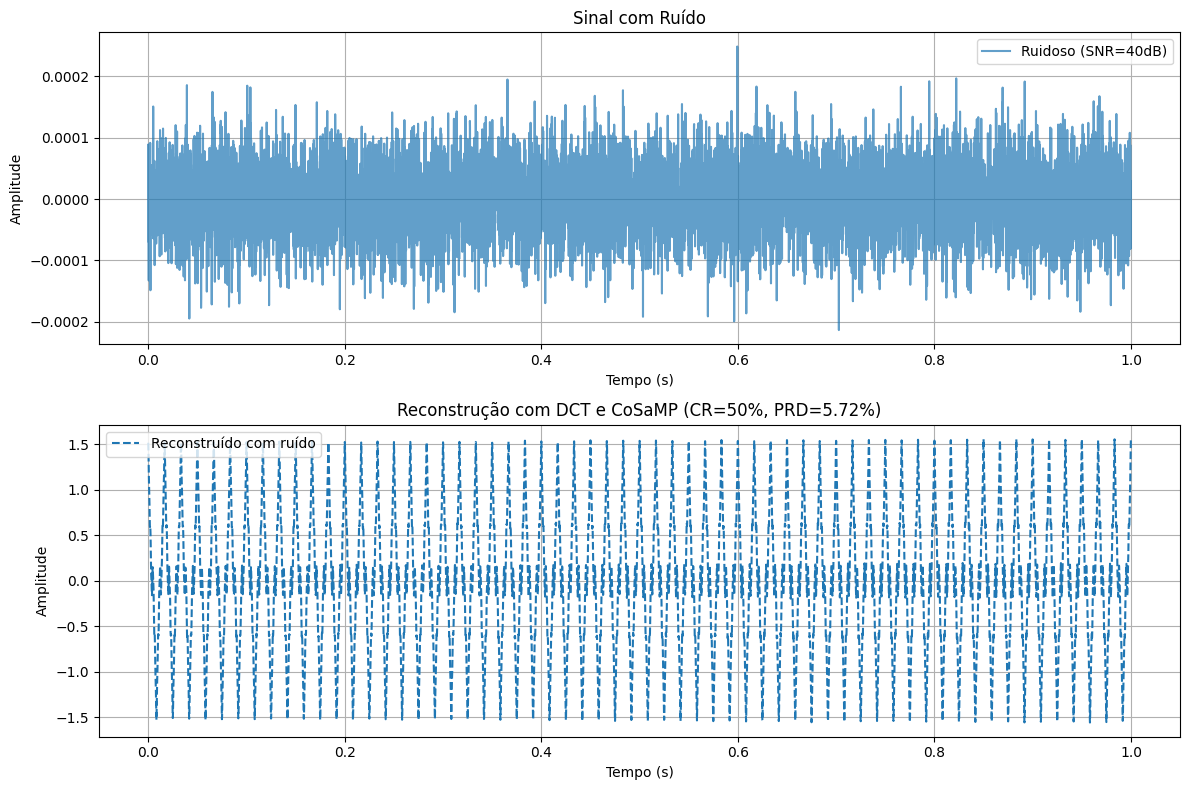

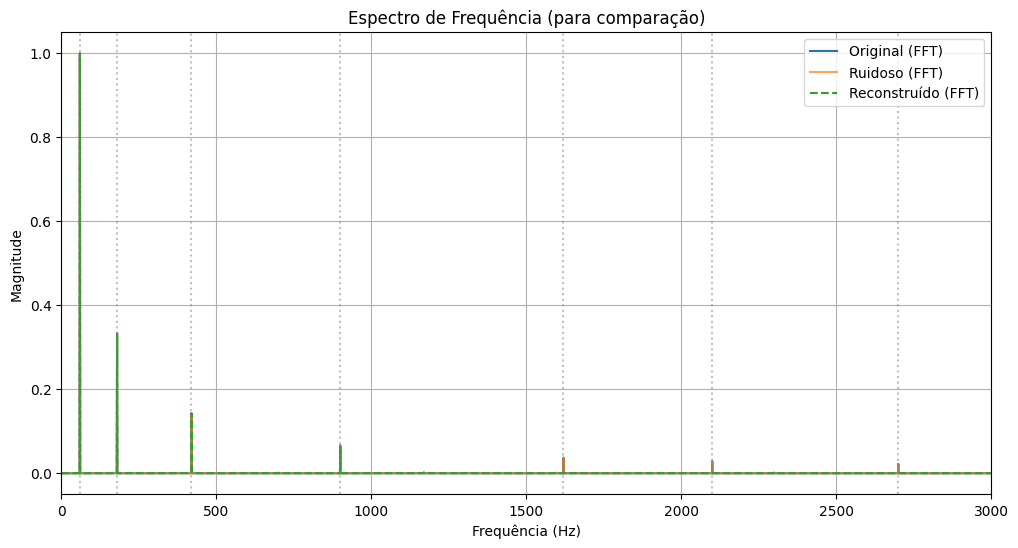

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct
print("cosamp, dct")
# Funções de métrica
def calculate_prd(original, reconstructed):
    return np.sqrt(np.sum((original - reconstructed) ** 2)) / np.sqrt(np.sum(original ** 2)) * 100

def calculate_rmse(original, reconstructed):
    return np.sqrt(np.mean((original - reconstructed) ** 2))

# Parâmetros do sinal
Fs = 8192       # Frequência de amostragem
Ts = 1 / Fs     # Período de amostragem
t = np.arange(Fs) * Ts  # Vetor de tempo
f = 60          # Frequência fundamental (Hz)

# Sinal harmônico com componentes ímpares
harm = [1, 3, 7, 15, 27, 35, 45]
y = np.sum([(1/h) * 1*np.cos(2 * np.pi * h * f * t) for h in harm], axis=0)

# DCT do sinal original
original_dct = 2*np.abs(np.fft.fft(y, norm='ortho'))/len(y)
#dct(y, norm='ortho')

# Adição de ruído gaussiano
SNR_dB = 40  # Razão sinal-ruído em dB
ruido = np.random.normal(0, np.mean(y**2) /(10 ** (SNR_dB / 10)), len(y))
y_ruidoso = y + ruido

# Compressive Sensing
CR = 50  # Taxa de compressão (60%)
N = len(y)
M = int(N * (100 - CR) / 100)  # Número de medidas

# Algoritmo COSAMP (1 iteração por chamada)
def cosamp(A, s, num_coefs=40):
    """
    COSAMP simplificado com 1 iteração.
    Retorna os coeficientes esparsos estimados.
    """
    r = s.copy()
    correlations = np.abs(A.T @ r)
    idx = np.argsort(correlations)[-2*num_coefs:]  # Seleciona 2*num_coefs candidatos
    A_selected = A[:, idx]
    x_selected = np.linalg.lstsq(A_selected, s, rcond=None)[0]

    # Mantém apenas os maiores coeficientes
    idx_top = np.argsort(np.abs(x_selected))[-num_coefs:]
    x = np.zeros(A.shape[1])
    x[idx[idx_top]] = x_selected[idx_top]

    return x

# Execução do experimento (200 iterações)
n_iterations = 5
prd_values = np.zeros(n_iterations)
prd_noisy_values = np.zeros(n_iterations)
rmse_values = np.zeros(n_iterations)
rmse_noisy_values = np.zeros(n_iterations)
harmonic_errors = np.zeros((n_iterations, len(harm)))

for i in range(n_iterations):
    print(f"Iteração {i+1}/{n_iterations}")
    # Amostragem aleatória diferente a cada iteração
    samples = np.random.choice(N, M, replace=False)
    samples.sort()

    # Matriz de medição (DCT subamostrada)
    A = dct(np.eye(N), norm='ortho')[samples, :]

    # Medições com e sem ruído
    clean_measurements = y[samples]
    noisy_measurements = y_ruidoso[samples]

    # Reconstrução com COSAMP (1 iteração)
    # Reconstrução do sinal limpo (para comparação)
    coeffs_clean = cosamp(A, clean_measurements, num_coefs=40)
    reconstructed_clean = idct(coeffs_clean, norm='ortho')
    reconstructed_clean = reconstructed_clean * (np.max(y) / np.max(reconstructed_clean))

    # Reconstrução do sinal ruidoso
    coeffs_noisy = cosamp(A, noisy_measurements, num_coefs=40)
    reconstructed_noisy = idct(coeffs_noisy, norm='ortho')
    #reconstructed_noisy = reconstructed_noisy #* (np.max(y_ruidoso) / np.max(reconstructed_noisy))

    # Cálculo das métricas
    prd_values[i] = calculate_prd(y, reconstructed_clean)
    prd_noisy_values[i] = calculate_prd(y, reconstructed_noisy)  # Comparando com o original sem ruído
    rmse_values[i] = calculate_rmse(y, reconstructed_clean)
    rmse_noisy_values[i] = calculate_rmse(y, reconstructed_noisy)

    # Erros nas harmônicas (usando a reconstrução ruidosa)
    recon_dct = 2*np.abs(np.fft.fft(reconstructed_noisy, norm='ortho'))/len(reconstructed_noisy)
    #for j, h in enumerate(harm):
    for j in range(len(harm)):
        #idx_h = int(h * f * N / Fs)
        idx_h = (int(harm[j]) * f/(Fs/N))
        #idx_h = (idx_h).astype(int)
        harmonic_errors[i, j] = 100*(np.abs(original_dct[(int(idx_h))]) - np.abs(recon_dct[(int(idx_h))]))/np.abs(original_dct[(int(idx_h))])

# Resultados finais
print("\nResultados para o sinal SEM ruído na entrada:")
print(f"PRD médio: {np.mean(prd_values):.2f}% ± {np.std(prd_values):.2f}%")
print(f"RMSE médio: {np.mean(rmse_values):.4f} ± {np.std(rmse_values):.4f}")

print("\nResultados para o sinal COM ruído (SNR = 20dB):")
print(f"PRD médio: {np.mean(prd_noisy_values):.2f}% ± {np.std(prd_noisy_values):.2f}%")
print(f"RMSE médio: {np.mean(rmse_noisy_values):.4f} ± {np.std(rmse_noisy_values):.4f}")
print("\nErros médios nas harmônicas (com ruído):")
for j, h in enumerate(harm):
    print(f"Harmônica {h}: {np.mean(harmonic_errors[:, j]):.4f} ± {np.std(harmonic_errors[:, j]):.4f}")

# Plot dos sinais
plt.figure(figsize=(12, 8))

# Sinal original vs ruidoso
plt.subplot(2, 1, 1)
#plt.plot(t, y, label='Original')
plt.plot(t, ruido, alpha=0.7, label=f'Ruidoso (SNR={SNR_dB}dB)')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Sinal com Ruído')
plt.grid()

# Sinal original vs reconstruído com ruído
plt.subplot(2, 1, 2)
#plt.plot(t, y, label='Original')
plt.plot(t, reconstructed_noisy, '--', label='Reconstruído com ruído')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.title(f'Reconstrução com DCT e CoSaMP (CR={CR}%, PRD={np.mean(prd_noisy_values):.2f}%)')
plt.grid()

plt.tight_layout()
plt.show()

# Plot do espectro DCT
freq = np.fft.fftfreq(N, Ts)[:N//2]
plt.figure(figsize=(12, 6))
plt.plot(freq, 2/N * np.abs(np.fft.fft(y)[0:N//2]), label='Original (FFT)')
plt.plot(freq, 2/N * np.abs(np.fft.fft(y_ruidoso)[0:N//2]), alpha=0.7, label='Ruidoso (FFT)')
plt.plot(freq, 2/N * np.abs(np.fft.fft(reconstructed_noisy)[0:N//2]), '--', label='Reconstruído (FFT)')
for h in harm:
    plt.axvline(h*f, color='gray', linestyle=':', alpha=0.5)
plt.xlim(0, 3000)
plt.xlabel('Frequência (Hz)')
plt.ylabel('Magnitude')
plt.title('Espectro de Frequência (para comparação)')
plt.legend()
plt.grid()
plt.show()




 **Resumo do Algoritmo**

Este algoritmo simula e avalia a reconstrução de um sinal harmônico utilizando **Compressed Sensing (CS)** com transformadas **DFT** e **DCT**, comparando o desempenho em sinais **limpos** e **com ruído**. A reconstrução é feita utilizando uma versão simplificada do algoritmo **CoSaMP**.

**Etapas principais:**

1. **Geração do Sinal Original:**
   - Sinal composto por harmônicas ímpares da frequência fundamental (60 Hz).
   - Tamanho do sinal: 8192 amostras.
   - Adição de ruído gaussiano com SNR de 20 dB.

2. **Configuração do Compressive Sensing:**
   - Taxa de compressão de 60% (somente 40% das amostras são usadas).
   - Seleção aleatória de amostras para cada iteração.

3. **Transformadas Utilizadas:**
   - **DFT (Transformada Discreta de Fourier)**.
   - **DCT (Transformada Cosseno Discreta)**.
   - Ambas são aplicadas sobre a base identidade para gerar a matriz de medição \( A \).

4. **Reconstrução via CoSaMP:**
   - Utiliza uma única iteração do CoSaMP para estimar coeficientes esparsos.
   - Reconstrói o sinal com base nesses coeficientes, utilizando a inversa da transformada correspondente (IFFT ou IDCT).
   - Sinal reconstruído é normalizado para comparação.

5. **Avaliação da Reconstrução:**
   - Métricas utilizadas:
     - **PRD (Percent Root Difference)**.
     - **RMSE (Root Mean Square Error)**.
     - **Erro nas harmônicas específicas** (comparação espectral ponto a ponto).

6. **Execução de Múltiplas Iterações:**
   - Repete o experimento `n_iterations` vezes (ex.: 2 vezes) para obter médias e desvios padrão das métricas.

7. **Visualizações:**
   - Plots dos sinais originais e reconstruídos (com e sem ruído).
   - Gráficos de barras comparando PRD e RMSE para DFT e DCT, com e sem ruído.

---



Iteração 1/2


<ipython-input-17-125b1520b75e>:47: ComplexWarning: Casting complex values to real discards the imaginary part
  x[idx[idx_top]] = x_selected[idx_top]


Iteração 2/2

=== Resultados Comparativos ===

DFT - Sinal limpo:
PRD médio: 10.21% ± 2.67%
RMSE médio: 0.0771 ± 0.0201
Erros médios nas harmônicas:
Harmônica 1: 329.3497 ± 90.6453
Harmônica 3: 104.3876 ± 27.6978
Harmônica 7: 42.8357 ± 15.8050
Harmônica 15: 141.8236 ± 131.2430
Harmônica 27: 151.7037 ± 0.0000
Harmônica 35: 117.0286 ± 0.0000
Harmônica 45: 91.0222 ± 0.0000

DFT - Sinal com ruído:
PRD médio: 20.34% ± 2.90%
RMSE médio: 0.1535 ± 0.0219
Erros médios nas harmônicas:
Harmônica 1: 792.5958 ± 105.7332
Harmônica 3: 264.5956 ± 32.5026
Harmônica 7: 104.0773 ± 24.1493
Harmônica 15: 167.5732 ± 105.4935
Harmônica 27: 151.7037 ± 0.0000
Harmônica 35: 117.0286 ± 0.0000
Harmônica 45: 91.0222 ± 0.0000

DCT - Sinal limpo:
PRD médio: 11.10% ± 2.20%
RMSE médio: 0.0837 ± 0.0166
Erros médios nas harmônicas:
Harmônica 1: 0.0000 ± 0.0000
Harmônica 3: 0.0000 ± 0.0000
Harmônica 7: 0.0000 ± 0.0000
Harmônica 15: 0.0000 ± 0.0000
Harmônica 27: 0.0000 ± 0.0000
Harmônica 35: 0.0000 ± 0.0000
Harmônica 45: 

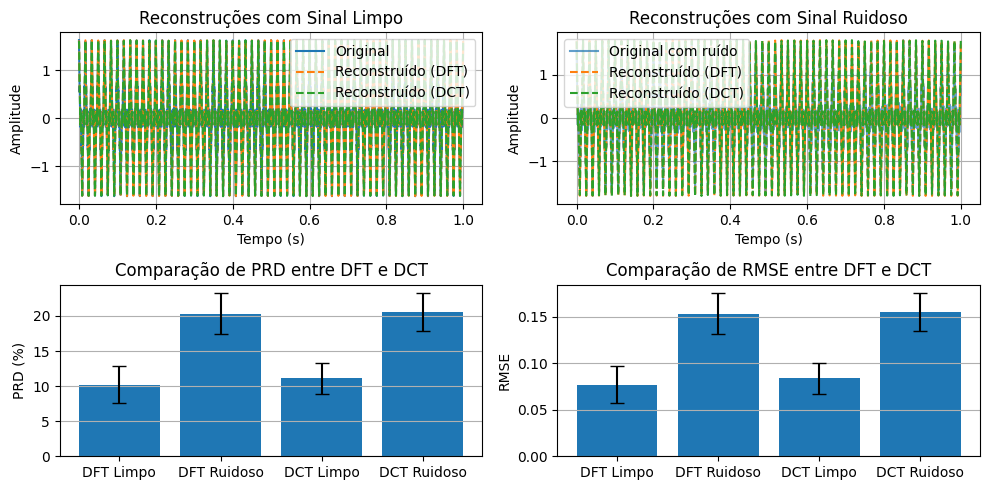

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct

# Funções de métrica
def calculate_prd(original, reconstructed):
    return np.sqrt(np.sum((original - reconstructed) ** 2) / np.sum(original ** 2)) * 100

def calculate_rmse(original, reconstructed):
    return np.sqrt(np.mean((original - reconstructed) ** 2))

# Parâmetros do sinal
Fs = 8192       # Frequência de amostragem
Ts = 1 / Fs     # Período de amostragem
t = np.arange(Fs) * Ts  # Vetor de tempo
f = 60          # Frequência fundamental (Hz)

# Sinal harmônico com componentes ímpares
harm = [1, 3, 7, 15, 27, 35, 45]
y = np.sum([(1/h) * np.cos(2 * np.pi * h * f * t) for h in harm], axis=0)

# Adição de ruído gaussiano
SNR_dB = 20  # Razão sinal-ruído em dB
ruido = np.random.normal(0, np.sqrt(np.var(y) / (10 ** (SNR_dB / 10))), len(y))
y_ruidoso = y + ruido

# Compressive Sensing
CR = 60  # Taxa de compressão (60%)
N = len(y)
M = int(N * (100 - CR) / 100)  # Número de medidas

# Algoritmo COSAMP (1 iteração por chamada)
def cosamp(A, s, num_coefs=14):
    """
    COSAMP simplificado com 1 iteração.
    Retorna os coeficientes esparsos estimados.
    """
    r = s.copy()
    correlations = np.abs(A.T @ r)
    idx = np.argsort(correlations)[-2*num_coefs:]  # Seleciona 2*num_coefs candidatos
    A_selected = A[:, idx]
    x_selected = np.linalg.lstsq(A_selected, s, rcond=None)[0]

    # Mantém apenas os maiores coeficientes
    idx_top = np.argsort(np.abs(x_selected))[-num_coefs:]
    x = np.zeros(A.shape[1])
    x[idx[idx_top]] = x_selected[idx_top]

    return x

# Execução do experimento (200 iterações)
n_iterations = 2
results = {
    'DFT_clean': {'prd': np.zeros(n_iterations), 'rmse': np.zeros(n_iterations), 'harmonic_errors': np.zeros((n_iterations, len(harm)))},
    'DFT_noisy': {'prd': np.zeros(n_iterations), 'rmse': np.zeros(n_iterations), 'harmonic_errors': np.zeros((n_iterations, len(harm)))},
    'DCT_clean': {'prd': np.zeros(n_iterations), 'rmse': np.zeros(n_iterations), 'harmonic_errors': np.zeros((n_iterations, len(harm)))},
    'DCT_noisy': {'prd': np.zeros(n_iterations), 'rmse': np.zeros(n_iterations), 'harmonic_errors': np.zeros((n_iterations, len(harm)))}
}

for i in range(n_iterations):
    print(f"Iteração {i+1}/{n_iterations}")

    # Amostragem aleatória diferente a cada iteração
    samples = np.random.choice(N, M, replace=False)
    samples.sort()

    # Configurações para DFT e DCT
    for transform in ['DFT', 'DCT']:
        # Matriz de medição
        if transform == 'DFT':
            A = np.fft.fft(np.eye(N), axis=0)[samples, :] / np.sqrt(N)
        else:  # DCT
            A = dct(np.eye(N), norm='ortho')[samples, :]

        # Processamento para sinal limpo e ruidoso
        for signal_type, signal in [('clean', y), ('noisy', y_ruidoso)]:
            measurements = signal[samples]

            # Reconstrução com COSAMP
            coeffs = cosamp(A, measurements, num_coefs=14)

            # Reconstrução do sinal
            if transform == 'DFT':
                reconstructed = np.real(np.fft.ifft(coeffs))
            else:  # DCT
                reconstructed = idct(coeffs, norm='ortho')

            # Normalização
            reconstructed = reconstructed * (np.max(signal) / np.max(reconstructed))

            # Cálculo das métricas (sempre comparando com o original limpo)
            key = f"{transform}_{signal_type}"
            results[key]['prd'][i] = calculate_prd(y, reconstructed)
            results[key]['rmse'][i] = calculate_rmse(y, reconstructed)

            # Análise espectral
            if transform == 'DFT':
                recon_spectrum = np.fft.fft(reconstructed)
                original_spectrum = np.fft.fft(y)
            else:  # DCT
                recon_spectrum = dct(reconstructed, norm='ortho')
                original_spectrum = dct(y, norm='ortho')

            # Erros nas harmônicas
            for j, h in enumerate(harm):
                idx_h = int(h * f * N / Fs)
                results[key]['harmonic_errors'][i, j] = np.abs(original_spectrum[idx_h] - recon_spectrum[idx_h])

# Resultados finais
print("\n=== Resultados Comparativos ===")
for transform in ['DFT', 'DCT']:
    for signal_type in ['clean', 'noisy']:
        key = f"{transform}_{signal_type}"
        prd_mean = np.mean(results[key]['prd'])
        prd_std = np.std(results[key]['prd'])
        rmse_mean = np.mean(results[key]['rmse'])
        rmse_std = np.std(results[key]['rmse'])

        print(f"\n{transform} - Sinal {'com ruído' if signal_type == 'noisy' else 'limpo'}:")
        print(f"PRD médio: {prd_mean:.2f}% ± {prd_std:.2f}%")
        print(f"RMSE médio: {rmse_mean:.4f} ± {rmse_std:.4f}")

        # Erros médios nas harmônicas
        harmonic_errors_mean = np.mean(results[key]['harmonic_errors'], axis=0)
        harmonic_errors_std = np.std(results[key]['harmonic_errors'], axis=0)
        print("Erros médios nas harmônicas:")
        for j, h in enumerate(harm):
            print(f"Harmônica {h}: {harmonic_errors_mean[j]:.4f} ± {harmonic_errors_std[j]:.4f}")

# Plot comparativo
plt.figure(figsize=(10, 5))

# Sinal original vs reconstruções
plt.subplot(2, 2, 1)
plt.plot(t, y, label='Original')
for transform in ['DFT', 'DCT']:
    # Usamos a última reconstrução como exemplo
    if transform == 'DFT':
        recon = np.real(np.fft.ifft(cosamp(np.fft.fft(np.eye(N), norm='ortho')[samples, :], y[samples])))
    else:
        recon = idct(cosamp(dct(np.eye(N), norm='ortho')[samples, :], y[samples]), norm='ortho')
    recon = recon * (np.max(y) / np.max(recon))
    plt.plot(t, recon, '--', label=f'Reconstruído ({transform})')
plt.title('Reconstruções com Sinal Limpo')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()

# Sinal ruidoso vs reconstruções
plt.subplot(2, 2, 2)
plt.plot(t, y_ruidoso, alpha=0.7, label='Original com ruído')
for transform in ['DFT', 'DCT']:
    # Usamos a última reconstrução como exemplo
    if transform == 'DFT':
        recon = np.real(np.fft.ifft(cosamp(np.fft.fft(np.eye(N), norm='ortho')[samples, :], y_ruidoso[samples])))
    else:
        recon = idct(cosamp(dct(np.eye(N), norm='ortho')[samples, :], y_ruidoso[samples]), norm='ortho')
    recon = recon * (np.max(y_ruidoso) / np.max(recon))
    plt.plot(t, recon, '--', label=f'Reconstruído ({transform})')
plt.title('Reconstruções com Sinal Ruidoso')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()

# Comparação de PRD
plt.subplot(2, 2, 3)
labels = ['DFT Limpo', 'DFT Ruidoso', 'DCT Limpo', 'DCT Ruidoso']
prd_means = [
    np.mean(results['DFT_clean']['prd']),
    np.mean(results['DFT_noisy']['prd']),
    np.mean(results['DCT_clean']['prd']),
    np.mean(results['DCT_noisy']['prd'])
]
prd_stds = [
    np.std(results['DFT_clean']['prd']),
    np.std(results['DFT_noisy']['prd']),
    np.std(results['DCT_clean']['prd']),
    np.std(results['DCT_noisy']['prd'])
]
plt.bar(labels, prd_means, yerr=prd_stds, capsize=5)
plt.ylabel('PRD (%)')
plt.title('Comparação de PRD entre DFT e DCT')
plt.grid(axis='y')

# Comparação de RMSE
plt.subplot(2, 2, 4)
rmse_means = [
    np.mean(results['DFT_clean']['rmse']),
    np.mean(results['DFT_noisy']['rmse']),
    np.mean(results['DCT_clean']['rmse']),
    np.mean(results['DCT_noisy']['rmse'])
]
rmse_stds = [
    np.std(results['DFT_clean']['rmse']),
    np.std(results['DFT_noisy']['rmse']),
    np.std(results['DCT_clean']['rmse']),
    np.std(results['DCT_noisy']['rmse'])
]
plt.bar(labels, rmse_means, yerr=rmse_stds, capsize=5)
plt.ylabel('RMSE')
plt.title('Comparação de RMSE entre DFT e DCT')
plt.grid(axis='y')

plt.tight_layout()
plt.show()

# Uso do algoritmo cosamp com a dft:

* Em um sinal sem ruído e outro com ruído.

Iteração 1/2


<ipython-input-32-281c6faa51c3>:46: ComplexWarning: Casting complex values to real discards the imaginary part
  x[idx[idx_top]] = x_selected[idx_top]


Iteração 2/2

=== Resultados Comparativos ===

DFT - Sinal limpo:
PRD médio: 7.43% ± 0.05%
RMSE médio: 0.0561 ± 0.0004

DFT - Sinal com ruído:
PRD médio: 14.77% ± 0.17%
RMSE médio: 0.1114 ± 0.0013


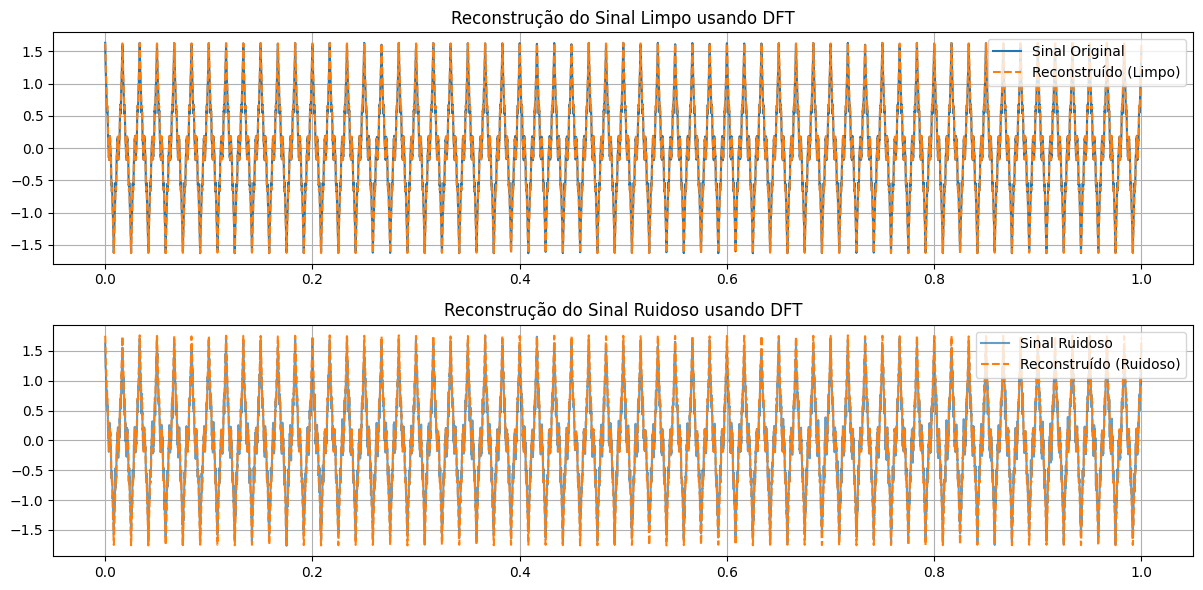

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Funções de métrica
def calculate_prd(original, reconstructed):
    return np.sqrt(np.sum((original - reconstructed) ** 2) / np.sum(original ** 2)) * 100

def calculate_rmse(original, reconstructed):
    return np.sqrt(np.mean((original - reconstructed) ** 2))

# Parâmetros do sinal
Fs = 8192  # Frequência de amostragem
Ts = 1 / Fs  # Período de amostragem
t = np.arange(Fs) * Ts  # Vetor de tempo
f = 60  # Frequência fundamental (Hz)
harm = [1, 3, 7, 15, 27, 35, 45]

# Sinal harmônico com componentes ímpares
y = np.sum([(1/h) * np.cos(2 * np.pi * h * f * t) for h in harm], axis=0)

# Adição de ruído gaussiano
SNR_dB = 20  # Razão sinal-ruído em dB
ruido = np.random.normal(0, np.sqrt(np.var(y) / (10 ** (SNR_dB / 10))), len(y))
y_ruidoso = y + ruido

# Compressive Sensing
CR = 60  # Taxa de compressão (60%)
N = len(y)
M = int(N * (100 - CR) / 100)  # Número de medidas

# Algoritmo COSAMP (1 iteração por chamada)
def cosamp(A, s, num_coefs=14):
    """
    COSAMP simplificado com 1 iteração.
    Retorna os coeficientes esparsos estimados.
    """
    r = s.copy()
    correlations = np.abs(A.T @ r)
    idx = np.argsort(correlations)[-2*num_coefs:]  # Seleciona 2*num_coefs candidatos
    A_selected = A[:, idx]
    x_selected = np.linalg.lstsq(A_selected, s, rcond=None)[0]

    # Mantém apenas os maiores coeficientes
    idx_top = np.argsort(np.abs(x_selected))[-num_coefs:]
    x = np.zeros(A.shape[1])
    x[idx[idx_top]] = x_selected[idx_top]

    return x

# Execução do experimento (200 iterações)
n_iterations = 2
results = {
    'DFT_clean': {'prd': np.zeros(n_iterations), 'rmse': np.zeros(n_iterations)},
    'DFT_noisy': {'prd': np.zeros(n_iterations), 'rmse': np.zeros(n_iterations)}
}

for i in range(n_iterations):
    print(f"Iteração {i+1}/{n_iterations}")

    # Amostragem aleatória diferente a cada iteração
    samples = np.random.choice(N, M, replace=False)
    samples.sort()

    # Matriz de medição (DFT subamostrada)
    A = np.fft.fft(np.eye(N), axis=0)[samples, :] / np.sqrt(N)

    # Medições com e sem ruído
    clean_measurements = y[samples]
    noisy_measurements = y_ruidoso[samples]

    # Reconstrução com COSAMP
    coeffs_clean = cosamp(A, clean_measurements, num_coefs=14)
    reconstructed_clean = np.real(np.fft.ifft(coeffs_clean))
    reconstructed_clean = reconstructed_clean * (np.max(y) / np.max(reconstructed_clean))

    coeffs_noisy = cosamp(A, noisy_measurements, num_coefs=14)
    reconstructed_noisy = np.real(np.fft.ifft(coeffs_noisy))
    reconstructed_noisy = reconstructed_noisy * (np.max(y_ruidoso) / np.max(reconstructed_noisy))

    # Cálculo das métricas
    results['DFT_clean']['prd'][i] = calculate_prd(y, reconstructed_clean)
    results['DFT_clean']['rmse'][i] = calculate_rmse(y, reconstructed_clean)
    results['DFT_noisy']['prd'][i] = calculate_prd(y, reconstructed_noisy)
    results['DFT_noisy']['rmse'][i] = calculate_rmse(y, reconstructed_noisy)

# Resultados finais
print("\n=== Resultados Comparativos ===")
for signal_type in ['clean', 'noisy']:
    key = f"DFT_{signal_type}"
    prd_mean = np.mean(results[key]['prd'])
    prd_std = np.std(results[key]['prd'])
    rmse_mean = np.mean(results[key]['rmse'])
    rmse_std = np.std(results[key]['rmse'])

    print(f"\nDFT - Sinal {'com ruído' if signal_type == 'noisy' else 'limpo'}:")
    print(f"PRD médio: {prd_mean:.2f}% ± {prd_std:.2f}%")
    print(f"RMSE médio: {rmse_mean:.4f} ± {rmse_std:.4f}")

# Gráficos
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t, y, label='Sinal Original')
plt.plot(t, reconstructed_clean, '--', label='Reconstruído (Limpo)')
plt.legend()
plt.title('Reconstrução do Sinal Limpo usando DFT')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(t, y_ruidoso, alpha=0.7, label='Sinal Ruidoso')
plt.plot(t, reconstructed_noisy, '--', label='Reconstruído (Ruidoso)')
plt.legend()
plt.title('Reconstrução do Sinal Ruidoso usando DFT')
plt.grid()

plt.tight_layout()
plt.show()


###  Análise do Algoritmo de Reconstrução com CoSaMP e Amostragem Compressiva

Este notebook implementa um sistema de **Amostragem Compressiva (Compressed Sensing)** utilizando a transformada discreta de Fourier (DFT) como base esparsa e o algoritmo **CoSaMP (Compressive Sampling Matching Pursuit)** para a reconstrução do sinal.

---

####  Parâmetros e Geração do Sinal
- O sinal original é composto por uma frequência fundamental de 60 Hz e múltiplas harmônicas (1ª, 3ª, 7ª, 15ª, 27ª, 35ª e 45ª), simulando uma forma de onda rica em componentes harmônicas.
- Amostragem: 8192 amostras a 8192 Hz (sinal de 1 segundo).

---

####  Amostragem Compressiva
- Taxa de compressão: **70%**, utilizando apenas **30% das amostras** do sinal original.
- A matriz de medição é construída a partir de linhas aleatórias da matriz DFT, e tanto a parte real quanto imaginária são utilizadas.

---

####  Reconstrução com CoSaMP
- O algoritmo CoSaMP identifica iterativamente os coeficientes mais relevantes, refinando a estimativa com base no erro residual.
- A reconstrução final é obtida pela aplicação da IFFT nos coeficientes esparsos estimados.

---

####  Métricas de Desempenho
- **PRD (Percent Root Difference)**: mede a diferença percentual entre os sinais original e reconstruído.
- **RMSE (Root Mean Square Error)**: erro médio quadrático entre os dois sinais.

---

#### Resultados Gráficos
- **Gráfico no tempo**: compara o sinal original com o sinal reconstruído.
- **Espectro de frequência**: mostra os componentes espectrais do sinal original e da reconstrução.

---





iteração: 1
iteração: 2
iteração: 3
iteração: 4
iteração: 5
iteração: 6
iteração: 7
iteração: 8
iteração: 9
iteração: 10
iteração: 11
iteração: 12
iteração: 13
iteração: 14
PRD: 0.00%
RMSE: 0.0000


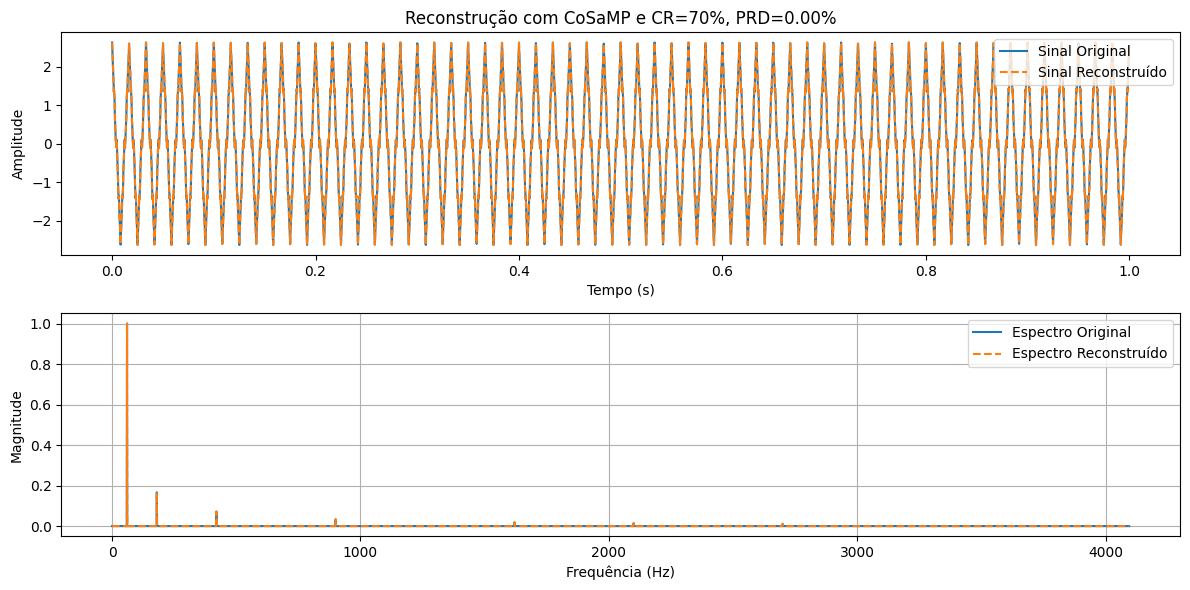

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parâmetros iniciais
N = 8192  # Tamanho do sinal
Fs = 8192  # Frequência de amostragem
f = 60  # Frequência fundamental
Ts = 1 / Fs
t = np.linspace(0, (N - 1) * Ts, N)
harm = [1, 3, 7, 15, 27, 35, 45]

# Sinal original
y = np.cos(2 * np.pi * f * t)
for h in harm:
    y += (1 / h) * np.cos(2 * np.pi * h * f * t)

# Aplicação da DFT ao sinal original
original_fft = np.fft.fft(y) / len(y)
frequencies = np.fft.fftfreq(len(y), d=Ts)

# Amostragem compressiva
CR = 70  # Taxa de compressão (%)
M = int(N * (100 - CR) / 100)  # Número de medições
amostras_aleatorias = np.random.choice(N, M, replace=False)
amostras_aleatorias.sort()

# Matriz de medição baseada na DFT
A_complex = np.fft.fft(np.eye(N)) / np.sqrt(N)
A_complex = A_complex[amostras_aleatorias, :]
A_real = np.vstack([np.real(A_complex), np.imag(A_complex)])

# Amostras compressivas
s = y[amostras_aleatorias]
s_real = np.hstack([np.real(s), np.imag(s)])

# Função CoSaMP
def cosamp(A, b, sparsity, iterations=14):
    x_recon = np.zeros(A.shape[1])
    residual = b
    for i in range(iterations):
        print(f"iteração: {i+1}")

        # Correlação com o residual
        corr = A.T @ residual

        # Seleção de índices candidatos
        indices = np.argsort(np.abs(corr))[-2 * sparsity:]
        selected_indices = np.union1d(np.nonzero(x_recon)[0], indices)

        # Resolução do sistema sobredeterminado
        A_selected = A[:, selected_indices]
        x_temp = np.zeros(A.shape[1])
        x_temp[selected_indices] = np.linalg.lstsq(A_selected, b, rcond=None)[0]

        # Atualiza o residual e a solução
        residual = b - A @ x_temp
        x_recon = x_temp
    return x_recon

# Reconstrução
reconstructed_coeffs = cosamp(A_real, s_real, sparsity=14)
reconstructed_signal = np.fft.ifft(reconstructed_coeffs)
reconstructed_signal = np.real(reconstructed_signal)
reconstructed_signal *= np.max(y) / np.max(reconstructed_signal)  # Normalização

# Métricas de desempenho
def calculate_prd(original, reconstructed):
    return np.sqrt(np.sum((original - reconstructed) ** 2) / np.sum(original ** 2)) * 100

def calculate_rmse(original, reconstructed):
    return np.sqrt(np.mean((original - reconstructed) ** 2))

prd = calculate_prd(y, reconstructed_signal)
rmse = calculate_rmse(y, reconstructed_signal)

# Resultados
print(f"PRD: {prd:.2f}%")
print(f"RMSE: {rmse:.4f}")

# Gráficos
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(t, y, label='Sinal Original')
plt.plot(t, reconstructed_signal, label='Sinal Reconstruído', linestyle='dashed')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.title(f'Reconstrução com CoSaMP e CR={CR}%, PRD={prd:.2f}%')

plt.subplot(2, 1, 2)
plt.plot(frequencies[:N//2], np.abs(original_fft[:N//2]), label='Espectro Original')
plt.plot(frequencies[:N//2],
         np.abs(np.fft.fft(reconstructed_signal)[:N//2]) / N,
         label='Espectro Reconstruído', linestyle='dashed')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Magnitude')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()




**Explicação do algoritmo CoSaMP aplicado à reconstrução compressiva de sinais:**

O algoritmo **CoSaMP (Compressive Sampling Matching Pursuit)** é uma técnica iterativa utilizada para a **reconstrução de sinais esparsos** a partir de um número reduzido de amostras, como ocorre em **Amostragem Compressiva (Compressive Sensing - CS)**. No contexto deste experimento, um sinal harmônico composto por múltiplas frequências é inicialmente gerado e corrompido por ruído branco gaussiano com **SNR = 20 dB**. Em seguida, é realizada uma amostragem aleatória de apenas **30%** dos pontos do sinal original (Taxa de Compressão CR = 70%).

A reconstrução é feita utilizando a matriz de medição baseada na DFT (Transformada Discreta de Fourier), e o CoSaMP recupera o vetor esparso no domínio da frequência por meio de um processo iterativo de seleção de componentes mais relevantes, projeção por mínimos quadrados e atualização do resíduo. Por fim, aplica-se a transformada inversa de Fourier para recuperar o sinal no domínio do tempo. As métricas **PRD (Percent Root-mean-square Difference)** e **RMSE (Root Mean Square Error)** são utilizadas para avaliar a qualidade da reconstrução em relação ao sinal original sem ruído.



Aplicando CoSaMP com amostragem compressiva sobre um sinal harmônico contaminado com ruído branco gaussiano (SNR = 20 dB).
Após a reconstrução, serão exibidas as métricas PRD e RMSE, e gráficos comparando o sinal original, o sinal ruidoso e o sinal reconstruído.
iteração: 1
iteração: 2
iteração: 3
iteração: 4
iteração: 5
iteração: 6
iteração: 7
iteração: 8
iteração: 9
iteração: 10
iteração: 11
iteração: 12
iteração: 13
iteração: 14

PRD: 9.36%
RMSE: 0.1347


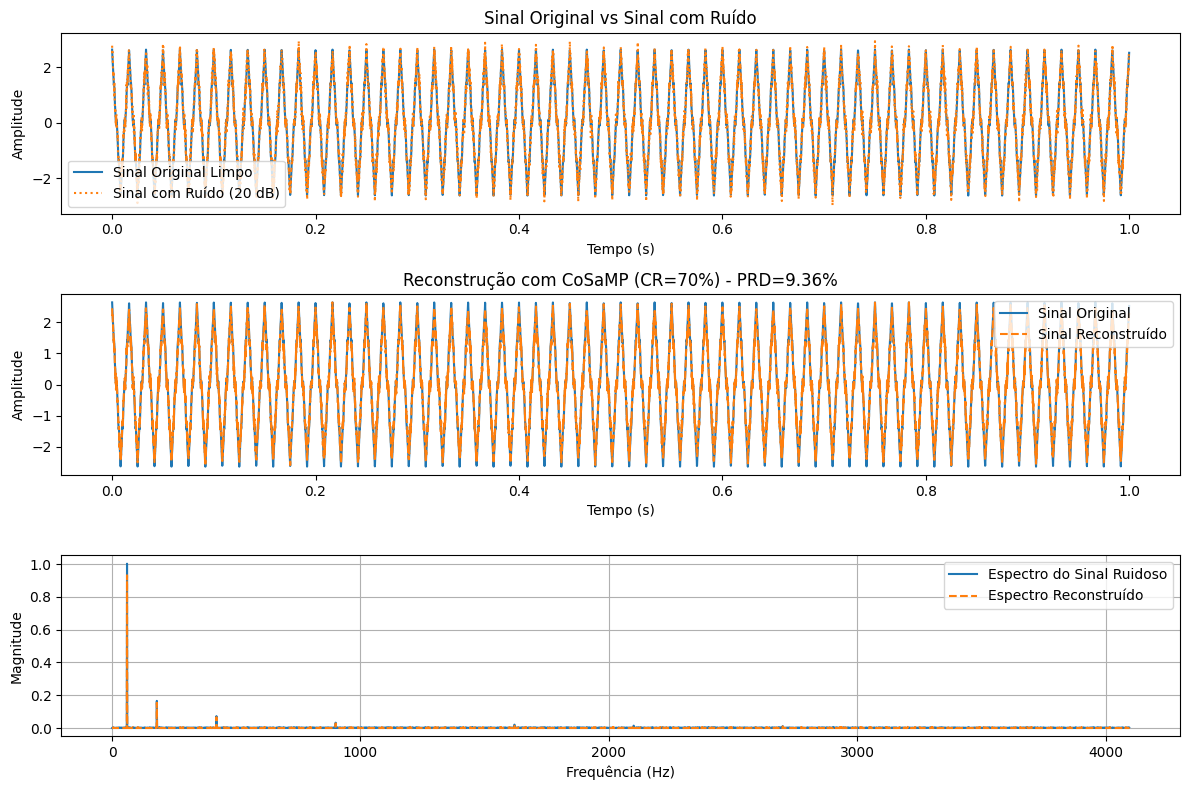

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

print("Aplicando CoSaMP com amostragem compressiva sobre um sinal harmônico contaminado com ruído branco gaussiano (SNR = 20 dB).")
print("Após a reconstrução, serão exibidas as métricas PRD e RMSE, e gráficos comparando o sinal original, o sinal ruidoso e o sinal reconstruído.")

# Parâmetros iniciais
N = 8192
Fs = 8192
f = 60
Ts = 1 / Fs
t = np.linspace(0, (N - 1) * Ts, N)
harm = [1, 3, 7, 15, 27, 35, 45]

# Sinal original
y_clean = np.cos(2 * np.pi * f * t)
for h in harm:
    y_clean += (1 / h) * np.cos(2 * np.pi * h * f * t)

# Adição de ruído (SNR = 20 dB)
def add_awgn(signal, snr_db):
    signal_power = np.mean(signal**2)
    snr_linear = 10**(snr_db / 10)
    noise_power = signal_power / snr_linear
    noise = np.random.normal(0, np.sqrt(noise_power), signal.shape)
    return signal + noise

y = add_awgn(y_clean, snr_db=20)

# FFT do sinal original ruidoso
original_fft = np.fft.fft(y) / len(y)
frequencies = np.fft.fftfreq(len(y), d=Ts)

# Amostragem compressiva
CR = 70
M = int(N * (100 - CR) / 100)
amostras_aleatorias = np.random.choice(N, M, replace=False)
amostras_aleatorias.sort()

# Matriz de medição baseada na DFT
A_complex = np.fft.fft(np.eye(N)) / np.sqrt(N)
A_complex = A_complex[amostras_aleatorias, :]
A_real = np.vstack([np.real(A_complex), np.imag(A_complex)])

# Amostras compressivas
s = y[amostras_aleatorias]
s_real = np.hstack([np.real(s), np.imag(s)])

# Função CoSaMP
def cosamp(A, b, sparsity, iterations=14):
    x_recon = np.zeros(A.shape[1])
    residual = b
    for i in range(iterations):
        print(f"iteração: {i+1}")

        corr = A.T @ residual
        indices = np.argsort(np.abs(corr))[-2 * sparsity:]
        selected_indices = np.union1d(np.nonzero(x_recon)[0], indices)

        A_selected = A[:, selected_indices]
        x_temp = np.zeros(A.shape[1])
        x_temp[selected_indices] = np.linalg.lstsq(A_selected, b, rcond=None)[0]

        residual = b - A @ x_temp
        x_recon = x_temp
    return x_recon

# Reconstrução
reconstructed_coeffs = cosamp(A_real, s_real, sparsity=14)
reconstructed_signal = np.fft.ifft(reconstructed_coeffs)
reconstructed_signal = np.real(reconstructed_signal)
reconstructed_signal *= np.max(y_clean) / np.max(reconstructed_signal)

# Métricas
def calculate_prd(original, reconstructed):
    return np.sqrt(np.sum((original - reconstructed) ** 2) / np.sum(original ** 2)) * 100

def calculate_rmse(original, reconstructed):
    return np.sqrt(np.mean((original - reconstructed) ** 2))

prd = calculate_prd(y_clean, reconstructed_signal)
rmse = calculate_rmse(y_clean, reconstructed_signal)

# Resultados
print(f"\nPRD: {prd:.2f}%")
print(f"RMSE: {rmse:.4f}")

# Gráficos
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(t, y_clean, label='Sinal Original Limpo')
plt.plot(t, y, label='Sinal com Ruído (20 dB)', linestyle='dotted')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Sinal Original vs Sinal com Ruído')

plt.subplot(3, 1, 2)
plt.plot(t, y_clean, label='Sinal Original')
plt.plot(t, reconstructed_signal, label='Sinal Reconstruído', linestyle='dashed')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.title(f'Reconstrução com CoSaMP (CR={CR}%) - PRD={prd:.2f}%')

plt.subplot(3, 1, 3)
plt.plot(frequencies[:N//2], np.abs(original_fft[:N//2]), label='Espectro do Sinal Ruidoso')
plt.plot(frequencies[:N//2],
         np.abs(np.fft.fft(reconstructed_signal)[:N//2]) / N,
         label='Espectro Reconstruído', linestyle='dashed')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Magnitude')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


# Utilização do algortimo cosamp com a dft, nesse algoritmo o número de iterações é ajustado manulamente para 200, o que não é o melhor uso para este tipo de algoritmo, pois ele tem critérios próprios de convergência, usar apenas este critério de número de iterações não é o melhor uso dele.


iteração: 1
iteração: 2
iteração: 3
iteração: 4
iteração: 5
iteração: 6
iteração: 7
iteração: 8
iteração: 9
iteração: 10
iteração: 11
iteração: 12
iteração: 13
iteração: 14
iteração: 15
iteração: 16
iteração: 17
iteração: 18
iteração: 19
iteração: 20
iteração: 21
iteração: 22
iteração: 23
iteração: 24
iteração: 25
iteração: 26
iteração: 27
iteração: 28
iteração: 29
iteração: 30
iteração: 31
iteração: 32
iteração: 33
iteração: 34
iteração: 35
iteração: 36
iteração: 37
iteração: 38
iteração: 39
iteração: 40
iteração: 41
iteração: 42
iteração: 43
iteração: 44
iteração: 45
iteração: 46
iteração: 47
iteração: 48
iteração: 49
iteração: 50
iteração: 51
iteração: 52
iteração: 53
iteração: 54
iteração: 55
iteração: 56
iteração: 57
iteração: 58
iteração: 59
iteração: 60
iteração: 61
iteração: 62
iteração: 63
iteração: 64
iteração: 65
iteração: 66
iteração: 67
iteração: 68
iteração: 69
iteração: 70
iteração: 71
iteração: 72
iteração: 73
iteração: 74
iteração: 75
iteração: 76
iteração: 77
iteração

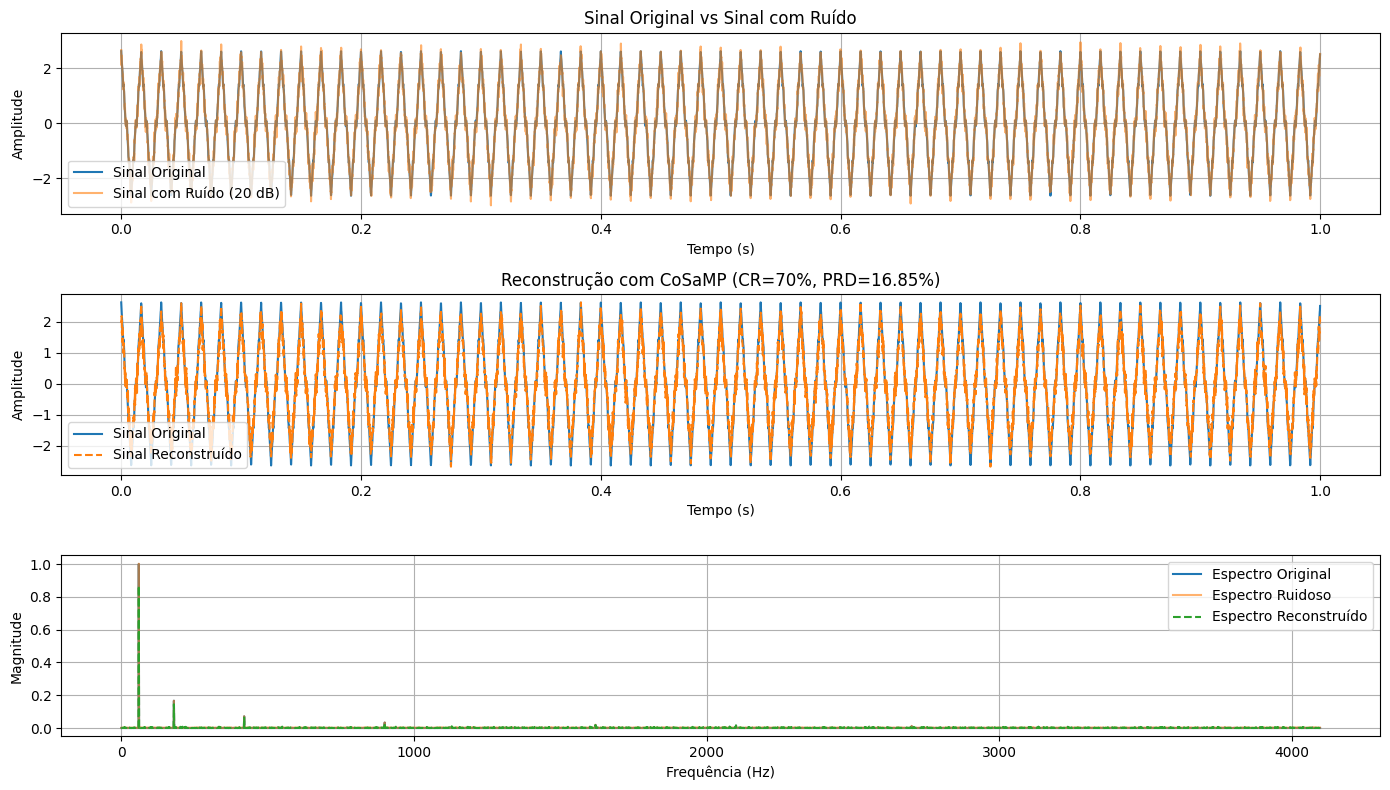

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parâmetros iniciais
N = 8192  # Tamanho do sinal
Fs = 8192  # Frequência de amostragem
f = 60  # Frequência fundamental
Ts = 1 / Fs
t = np.linspace(0, (N - 1) * Ts, N)
harm = [1, 3, 7, 15, 27, 35, 45]

# Sinal original
y = np.cos(2 * np.pi * f * t)
for h in harm:
    y += (1 / h) * np.cos(2 * np.pi * h * f * t)

# Adição de ruído gaussiano branco com SNR de 20 dB
def add_white_noise(signal, snr_db):
    signal_power = np.mean(signal**2)
    noise_power = signal_power / (10 ** (snr_db/10))
    noise = np.random.normal(0, np.sqrt(noise_power), len(signal))
    return signal + noise

snr_db = 20
y_noisy = add_white_noise(y, snr_db)

# Aplicação da DFT ao sinal original e ao sinal ruidoso
original_fft = np.fft.fft(y) / len(y)
noisy_fft = np.fft.fft(y_noisy) / len(y_noisy)
frequencies = np.fft.fftfreq(len(y), d=Ts)

# Amostragem compressiva
CR = 70  # Taxa de compressão (%)
M = int(N * (100 - CR) / 100)  # Número de medições
amostras_aleatorias = np.random.choice(N, M, replace=False)
amostras_aleatorias.sort()

# Matriz de medição baseada na DFT
A_complex = np.fft.fft(np.eye(N)) / np.sqrt(N)
A_complex = A_complex[amostras_aleatorias, :]
A_real = np.vstack([np.real(A_complex), np.imag(A_complex)])

# Amostras compressivas do sinal ruidoso
s = y_noisy[amostras_aleatorias]
s_real = np.hstack([np.real(s), np.imag(s)])

# Função CoSaMP
def cosamp(A, b, sparsity, iterations=200):
    x_recon = np.zeros(A.shape[1])
    residual = b
    for i in range(iterations):
        print(f"iteração: {i+1}")

        # Correlação com o residual
        corr = A.T @ residual

        # Seleção de índices candidatos
        indices = np.argsort(np.abs(corr))[-2 * sparsity:]
        selected_indices = np.union1d(np.nonzero(x_recon)[0], indices)

        # Resolução do sistema sobredeterminado
        A_selected = A[:, selected_indices]
        x_temp = np.zeros(A.shape[1])
        x_temp[selected_indices] = np.linalg.lstsq(A_selected, b, rcond=None)[0]

        # Atualiza o residual e a solução
        residual = b - A @ x_temp
        x_recon = x_temp
    return x_recon

# Reconstrução
reconstructed_coeffs = cosamp(A_real, s_real, sparsity=14)
reconstructed_signal = np.fft.ifft(reconstructed_coeffs)
reconstructed_signal = np.real(reconstructed_signal)
reconstructed_signal *= np.max(y) / np.max(reconstructed_signal)  # Normalização

# Métricas de desempenho
def calculate_prd(original, reconstructed):
    return np.sqrt(np.sum((original - reconstructed) ** 2) / np.sum(original ** 2)) * 100

def calculate_rmse(original, reconstructed):
    return np.sqrt(np.mean((original - reconstructed) ** 2))

prd = calculate_prd(y, reconstructed_signal)
rmse = calculate_rmse(y, reconstructed_signal)

# Resultados
print(f"\nSNR: {snr_db} dB")
print(f"PRD: {prd:.2f}%")
print(f"RMSE: {rmse:.4f}")

# Gráficos
plt.figure(figsize=(14, 8))

plt.subplot(3, 1, 1)
plt.plot(t, y, label='Sinal Original')
plt.plot(t, y_noisy, alpha=0.6, label=f'Sinal com Ruído ({snr_db} dB)')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Sinal Original vs Sinal com Ruído')
plt.grid()

plt.subplot(3, 1, 2)
plt.plot(t, y, label='Sinal Original')
plt.plot(t, reconstructed_signal, label='Sinal Reconstruído', linestyle='dashed')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.title(f'Reconstrução com CoSaMP (CR={CR}%, PRD={prd:.2f}%)')
plt.grid()

plt.subplot(3, 1, 3)
plt.plot(frequencies[:N//2], np.abs(original_fft[:N//2]), label='Espectro Original')
plt.plot(frequencies[:N//2], np.abs(noisy_fft[:N//2]), alpha=0.6, label='Espectro Ruidoso')
plt.plot(frequencies[:N//2],
         np.abs(np.fft.fft(reconstructed_signal)[:N//2]) / N,
         label='Espectro Reconstruído', linestyle='dashed')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Magnitude')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


SNR: 20 dB, CR: 70%
PRD: 8.99%
RMSE: 0.1293

Erro em cada harmônica:
Harmônica 1 (60 Hz): 6.19%
Harmônica 3 (180 Hz): 5.40%
Harmônica 7 (420 Hz): 9.47%
Harmônica 15 (900 Hz): 10.79%
Harmônica 27 (1620 Hz): 14.18%
Harmônica 35 (2100 Hz): 8.46%
Harmônica 45 (2700 Hz): 34.17%


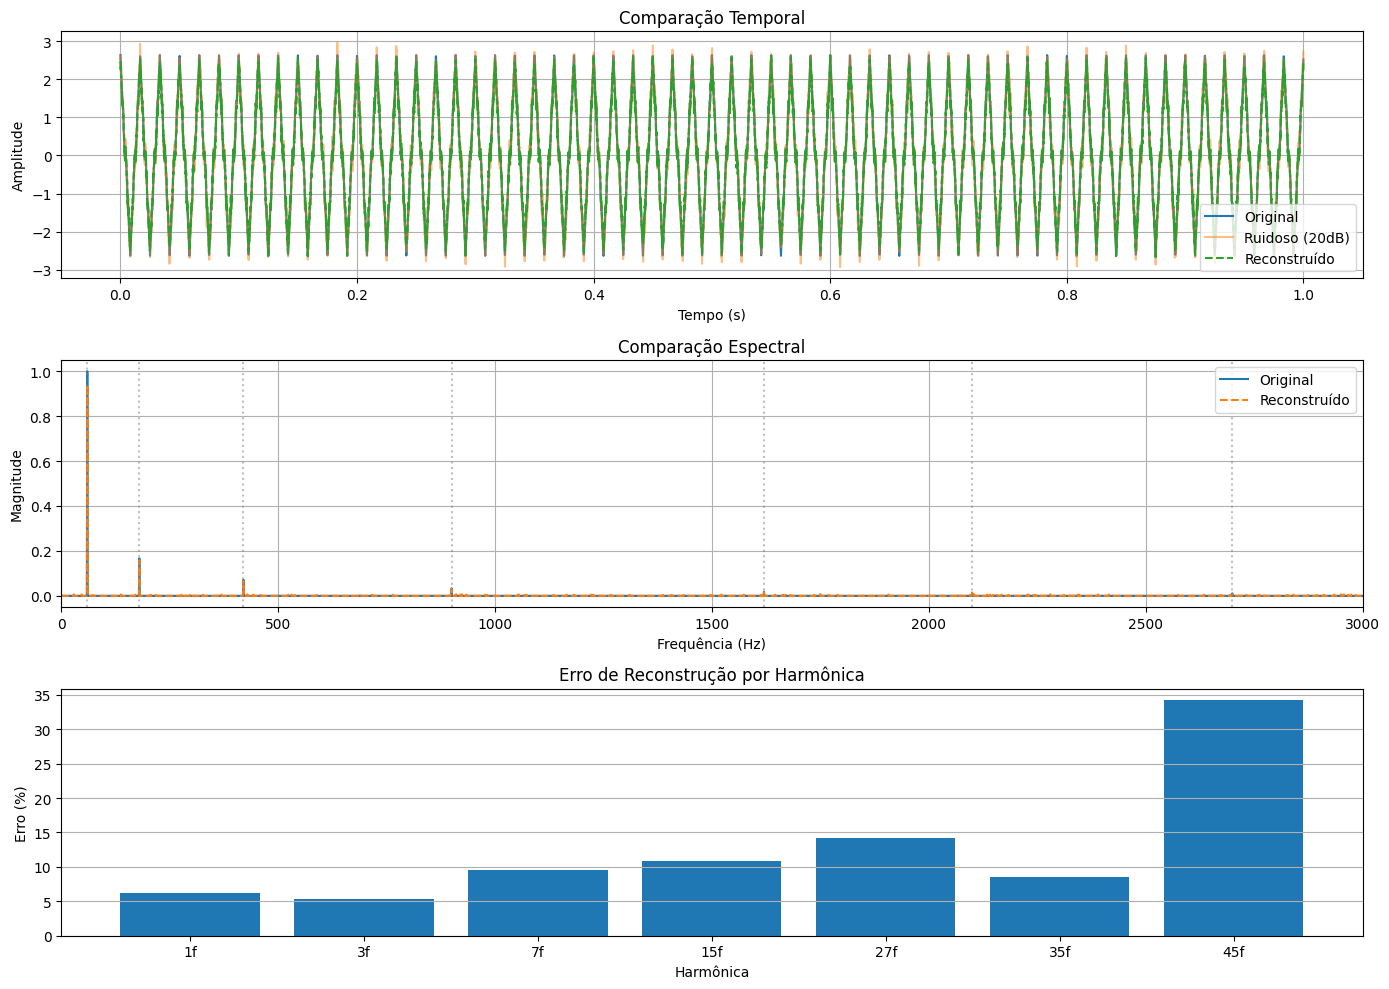

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parâmetros iniciais
N = 8192  # Tamanho do sinal
Fs = 8192  # Frequência de amostragem
f = 60  # Frequência fundamental
Ts = 1 / Fs
t = np.linspace(0, (N - 1) * Ts, N)
harm = [1, 3, 7, 15, 27, 35, 45]

# Sinal original
y = np.cos(2 * np.pi * f * t)
for h in harm:
    y += (1 / h) * np.cos(2 * np.pi * h * f * t)

# Adição de ruído gaussiano branco com SNR de 20 dB
def add_white_noise(signal, snr_db):
    signal_power = np.mean(signal**2)
    noise_power = signal_power / (10 ** (snr_db/10))
    noise = np.random.normal(0, np.sqrt(noise_power), len(signal))
    return signal + noise

snr_db = 20
y_noisy = add_white_noise(y, snr_db)

# Aplicação da DFT
original_fft = np.fft.fft(y) / len(y)
noisy_fft = np.fft.fft(y_noisy) / len(y_noisy)
frequencies = np.fft.fftfreq(len(y), d=Ts)

# Amostragem compressiva
CR = 70
M = int(N * (100 - CR) / 100)
amostras_aleatorias = np.random.choice(N, M, replace=False)
amostras_aleatorias.sort()

# Matriz de medição DFT
A_complex = np.fft.fft(np.eye(N)) / np.sqrt(N)
A_complex = A_complex[amostras_aleatorias, :]
A_real = np.vstack([np.real(A_complex), np.imag(A_complex)])

# Amostras compressivas
s = y_noisy[amostras_aleatorias]
s_real = np.hstack([np.real(s), np.imag(s)])

# Função CoSaMP
def cosamp(A, b, sparsity, iterations=14):
    x_recon = np.zeros(A.shape[1])
    residual = b
    for i in range(iterations):
        corr = A.T @ residual
        indices = np.argsort(np.abs(corr))[-2 * sparsity:]
        selected_indices = np.union1d(np.nonzero(x_recon)[0], indices)
        A_selected = A[:, selected_indices]
        x_temp = np.zeros(A.shape[1])
        x_temp[selected_indices] = np.linalg.lstsq(A_selected, b, rcond=None)[0]
        residual = b - A @ x_temp
        x_recon = x_temp
    return x_recon

# Reconstrução
reconstructed_coeffs = cosamp(A_real, s_real, sparsity=14)
reconstructed_signal = np.fft.ifft(reconstructed_coeffs)
reconstructed_signal = np.real(reconstructed_signal)
reconstructed_signal *= np.max(y) / np.max(reconstructed_signal)

# DFT do sinal reconstruído
reconstructed_fft = np.fft.fft(reconstructed_signal) / len(reconstructed_signal)

# Cálculo do erro em cada harmônica
harmonic_errors = []
harmonic_freqs = [h * f for h in harm]

for h_freq in harmonic_freqs:
    # Encontra o índice mais próximo da frequência harmônica
    idx = np.argmin(np.abs(frequencies - h_freq))

    # Magnitudes original e reconstruída
    mag_original = np.abs(original_fft[idx])
    mag_reconstructed = np.abs(reconstructed_fft[idx])

    # Cálculo do erro percentual
    error_percent = 100 * np.abs(mag_original - mag_reconstructed) / mag_original
    harmonic_errors.append(error_percent)

# Métricas de desempenho
def calculate_prd(original, reconstructed):
    return np.sqrt(np.sum((original - reconstructed) ** 2) / np.sum(original ** 2)) * 100

def calculate_rmse(original, reconstructed):
    return np.sqrt(np.mean((original - reconstructed) ** 2))

prd = calculate_prd(y, reconstructed_signal)
rmse = calculate_rmse(y, reconstructed_signal)

# Resultados
print(f"\nSNR: {snr_db} dB, CR: {CR}%")
print(f"PRD: {prd:.2f}%")
print(f"RMSE: {rmse:.4f}\n")

print("Erro em cada harmônica:")
for h, err in zip(harm, harmonic_errors):
    print(f"Harmônica {h} ({h*f} Hz): {err:.2f}%")

# Gráficos
plt.figure(figsize=(14, 10))

# Sinal no domínio do tempo
plt.subplot(3, 1, 1)
plt.plot(t, y, label='Original')
plt.plot(t, y_noisy, alpha=0.5, label=f'Ruidoso ({snr_db}dB)')
plt.plot(t, reconstructed_signal, '--', label='Reconstruído')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Comparação Temporal')
plt.grid()

# Espectro de frequência
plt.subplot(3, 1, 2)
plt.plot(frequencies[:N//2], np.abs(original_fft[:N//2]), label='Original')
plt.plot(frequencies[:N//2], np.abs(reconstructed_fft[:N//2]), '--', label='Reconstruído')
for h in harm:
    plt.axvline(h*f, color='gray', linestyle=':', alpha=0.5)
plt.xlim(0, 3000)
plt.xlabel('Frequência (Hz)')
plt.ylabel('Magnitude')
plt.legend()
plt.title('Comparação Espectral')
plt.grid()

# Erros por harmônica
plt.subplot(3, 1, 3)
plt.bar([f"{h}f" for h in harm], harmonic_errors)
plt.xlabel('Harmônica')
plt.ylabel('Erro (%)')
plt.title('Erro de Reconstrução por Harmônica')
plt.grid(axis='y')

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# [Configurações iniciais e geração do sinal permanecem iguais...]
# Parâmetros iniciais
N = 8192  # Tamanho do sinal
Fs = 8192  # Frequência de amostragem
f = 60  # Frequência fundamental
Ts = 1 / Fs
t = np.linspace(0, (N - 1) * Ts, N)
harm = [1, 3, 7, 15, 27, 35, 45]

# Sinal original
y = np.cos(2 * np.pi * f * t)
for h in harm:
    y += (1 / h) * np.cos(2 * np.pi * h * f * t)

# Adição de ruído gaussiano branco com SNR de 20 dB
def add_white_noise(signal, snr_db):
    signal_power = np.mean(signal**2)
    noise_power = signal_power / (10 ** (snr_db/10))
    noise = np.random.normal(0, np.sqrt(noise_power), len(signal))
    return signal + noise

snr_db = 20
y_noisy = add_white_noise(y, snr_db)

# Aplicação da DFT
original_fft = np.fft.fft(y) / len(y)
noisy_fft = np.fft.fft(y_noisy) / len(y_noisy)
frequencies = np.fft.fftfreq(len(y), d=Ts)

# Amostragem compressiva
CR = 70
M = int(N * (100 - CR) / 100)
amostras_aleatorias = np.random.choice(N, M, replace=False)
amostras_aleatorias.sort()

# Matriz de medição DFT
A_complex = np.fft.fft(np.eye(N)) / np.sqrt(N)
A_complex = A_complex[amostras_aleatorias, :]
A_real = np.vstack([np.real(A_complex), np.imag(A_complex)])

# Amostras compressivas
s = y_noisy[amostras_aleatorias]
s_real = np.hstack([np.real(s), np.imag(s)])

# Função CoSaMP
def cosamp(A, b, sparsity, iterations=14):
    x_recon = np.zeros(A.shape[1])
    residual = b
    for i in range(iterations):
        corr = A.T @ residual
        indices = np.argsort(np.abs(corr))[-2 * sparsity:]
        selected_indices = np.union1d(np.nonzero(x_recon)[0], indices)
        A_selected = A[:, selected_indices]
        x_temp = np.zeros(A.shape[1])
        x_temp[selected_indices] = np.linalg.lstsq(A_selected, b, rcond=None)[0]
        residual = b - A @ x_temp
        x_recon = x_temp
    return x_recon

# Reconstrução
reconstructed_coeffs = cosamp(A_real, s_real, sparsity=14)
reconstructed_signal = np.fft.ifft(reconstructed_coeffs)
reconstructed_signal = np.real(reconstructed_signal)
reconstructed_signal *= np.max(y) / np.max(reconstructed_signal)

# DFT do sinal reconstruído
reconstructed_fft = np.fft.fft(reconstructed_signal) / len(reconstructed_signal)

# Cálculo dos erros absolutos por harmônica
harmonic_errors = []
harmonic_magnitudes = {
    'original': [],
    'reconstructed': [],
    'error_abs': [],
    'error_percent': []
}

for h in harm:
    freq = h * f
    idx = np.argmin(np.abs(frequencies - freq))

    mag_original = np.abs(original_fft[idx])
    mag_reconstructed = np.abs(reconstructed_fft[idx])
    error_abs = np.abs(mag_original - mag_reconstructed)
    error_percent = 100 * error_abs / mag_original

    harmonic_magnitudes['original'].append(mag_original)
    harmonic_magnitudes['reconstructed'].append(mag_reconstructed)
    harmonic_magnitudes['error_abs'].append(error_abs)
    harmonic_magnitudes['error_percent'].append(error_percent)

# Exibição dos resultados em formato tabular
print("\nTabela de Erros por Harmônica")
print("-"*65)
print(f"{'Harmônica':<10} | {'Freq (Hz)':<10} | {'Original':<12} | {'Reconstruído':<12} | {'Erro Absoluto':<14} | {'Erro %':<10}")
print("-"*65)

for i, h in enumerate(harm):
    print(f"{h:<10} | {h*f:<10.1f} | {harmonic_magnitudes['original'][i]:<12.6f} | {harmonic_magnitudes['reconstructed'][i]:<12.6f} | "
          f"{harmonic_magnitudes['error_abs'][i]:<14.6f} | {harmonic_magnitudes['error_percent'][i]:<10.2f}")

# [Restante do código com gráficos permanece igual...]


Tabela de Erros por Harmônica
-----------------------------------------------------------------
Harmônica  | Freq (Hz)  | Original     | Reconstruído | Erro Absoluto  | Erro %    
-----------------------------------------------------------------
1          | 60.0       | 1.000000     | 0.954299     | 0.045701       | 4.57      
3          | 180.0      | 0.166667     | 0.153483     | 0.013184       | 7.91      
7          | 420.0      | 0.071429     | 0.068692     | 0.002737       | 3.83      
15         | 900.0      | 0.033333     | 0.031828     | 0.001505       | 4.52      
27         | 1620.0     | 0.018519     | 0.019885     | 0.001367       | 7.38      
35         | 2100.0     | 0.014286     | 0.011911     | 0.002375       | 16.62     
45         | 2700.0     | 0.011111     | 0.008678     | 0.002433       | 21.90     



RESULTADOS GLOBAIS
PRD: 3.40%
RMSE: 0.025680


ANÁLISE DAS HARMÔNICAS
Harm.  | Freq (Hz)  | Teórico (1/h) | Original (DFT) | Reconstruído   | Erro Abs.    | Erro %    
1      | 60.0       | 1.000000     | 1.000000       | 0.984529       | 0.015471     | 1.55      %
3      | 180.0      | 0.333333     | 0.333333       | 0.325752       | 0.007581     | 2.27      %
7      | 420.0      | 0.142857     | 0.142857       | 0.139100       | 0.003757     | 2.63      %
15     | 900.0      | 0.066667     | 0.066667       | 0.062074       | 0.004592     | 6.89      %
27     | 1620.0     | 0.037037     | 0.037037       | 0.038893       | 0.001856     | 5.01      %
35     | 2100.0     | 0.028571     | 0.028571       | 0.026087       | 0.002484     | 8.70      %
45     | 2700.0     | 0.022222     | 0.022222       | 0.018615       | 0.003607     | 16.23     %


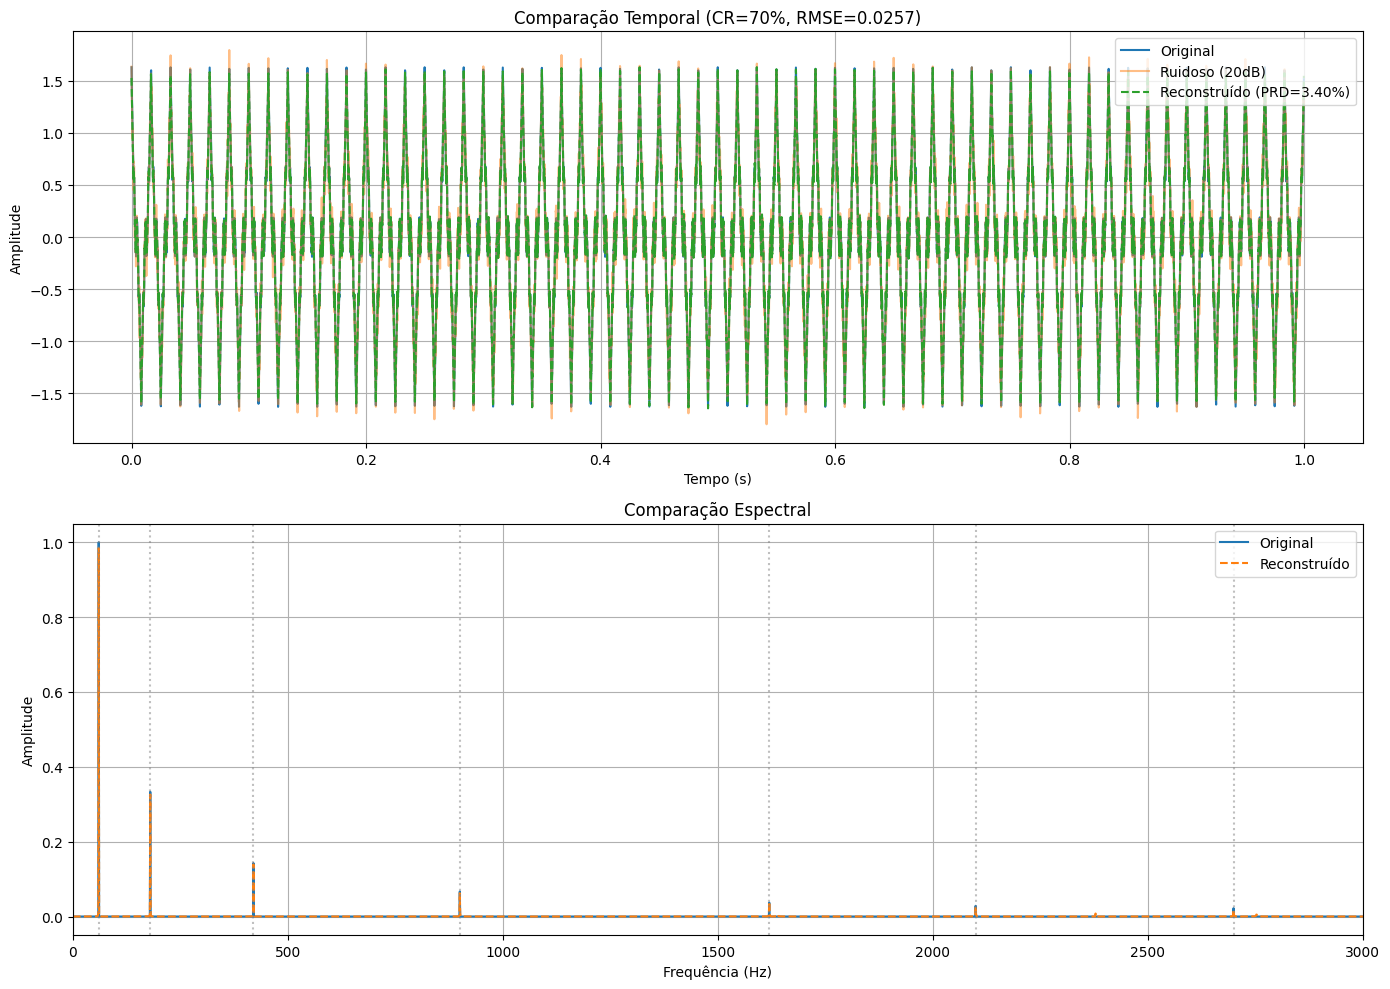

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct

# 1. Configurações do sinal
N = 8192
Fs = 8192
f = 60  # Frequência fundamental
Ts = 1/Fs
t = np.linspace(0, (N-1)*Ts, N)
harm = [1, 3, 7, 15, 27, 35, 45]

# 2. Geração do sinal original
y = np.sum([(1/h)*np.cos(2*np.pi*h*f*t) for h in harm], axis=0)

# 3. Adição de ruído (20 dB SNR)
snr_db = 20
ruido = np.random.normal(0, np.sqrt(np.var(y)/10**(snr_db/10)), N)
y_ruidoso = y + ruido

# 4. Compressive Sensing (70% CR)
CR = 70
M = int(N*(100-CR)/100)
samples = np.random.choice(N, M, replace=False)
samples.sort()

# 5. Matriz de medição (DCT)
A = dct(np.eye(N), norm='ortho')[samples, :]
measurements = y_ruidoso[samples]

# 6. Algoritmo OMP para reconstrução
def omp(A, y, k):
    n = A.shape[1]
    x = np.zeros(n)
    residual = y.copy()
    idx = []

    for _ in range(k):
        corr = np.abs(A.T @ residual)
        new_idx = np.argmax(corr)
        idx.append(new_idx)

        A_selected = A[:, idx]
        x_temp = np.linalg.lstsq(A_selected, y, rcond=None)[0]
        residual = y - A_selected @ x_temp

    x_recon = np.zeros(n)
    x_recon[idx] = x_temp
    return x_recon

# 7. Reconstrução (usando 26 coeficientes)
coeffs = omp(A, measurements, k=26)
reconstructed = idct(coeffs, norm='ortho')
reconstructed = reconstructed * (np.max(y)/np.max(reconstructed))

# 8. Cálculo das métricas globais
def calculate_prd(original, reconstructed):
    return np.sqrt(np.sum((original - reconstructed)**2) / np.sum(original**2)) * 100

def calculate_rmse(original, reconstructed):
    return np.sqrt(np.mean((original - reconstructed)**2))

prd = calculate_prd(y, reconstructed)
rmse = calculate_rmse(y, reconstructed)

# 9. Análise espectral
freqs = np.fft.fftfreq(N, Ts)[:N//2]
original_fft = np.fft.fft(y)[:N//2]/N
recon_fft = np.fft.fft(reconstructed)[:N//2]/N

# 10. Tabela de resultados COMPLETA
print("\nRESULTADOS GLOBAIS")
print(f"PRD: {prd:.2f}%")
print(f"RMSE: {rmse:.6f}\n")

print("\nANÁLISE DAS HARMÔNICAS")
print("="*90)
print(f"{'Harm.':<6} | {'Freq (Hz)':<10} | {'Teórico (1/h)':<12} | {'Original (DFT)':<14} | {'Reconstruído':<14} | {'Erro Abs.':<12} | {'Erro %':<10}")
print("="*90)

for h in harm:
    freq = h*f
    idx = np.argmin(np.abs(freqs - freq))

    teorico = 1/h
    original = 2*np.abs(original_fft[idx])  # Amplitude unilateral
    recon = 2*np.abs(recon_fft[idx])
    erro_abs = np.abs(original - recon)
    erro_perc = 100*erro_abs/original

    print(f"{h:<6} | {freq:<10.1f} | {teorico:<12.6f} | {original:<14.6f} | {recon:<14.6f} | {erro_abs:<12.6f} | {erro_perc:<10.2f}%")

# 11. Gráficos comparativos
plt.figure(figsize=(14, 10))

# Sinal no tempo
plt.subplot(2, 1, 1)
plt.plot(t, y, label='Original')
plt.plot(t, y_ruidoso, alpha=0.5, label=f'Ruidoso (20dB)')
plt.plot(t, reconstructed, '--', label=f'Reconstruído (PRD={prd:.2f}%)')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.title(f'Comparação Temporal (CR={CR}%, RMSE={rmse:.4f})')
plt.grid()

# Espectro de frequência
plt.subplot(2, 1, 2)
plt.plot(freqs, 2*np.abs(original_fft), label='Original')
plt.plot(freqs, 2*np.abs(recon_fft), '--', label='Reconstruído')
for h in harm:
    plt.axvline(h*f, color='gray', linestyle=':', alpha=0.5)
plt.xlim(0, 3000)
plt.xlabel('Frequência (Hz)')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Comparação Espectral')
plt.grid()

plt.tight_layout()
plt.show()

Uso do algoritmo cosamp com a dct em um sinal ruidoso de 20db.

Executando CoSaMP...
CoSaMP: Iteração 100/100 | Resíduo: 3.9586


RESULTADOS GLOBAIS
PRD: 4.37%
RMSE: 0.032936
CR: 70%
SNR: 20 dB

ANÁLISE DAS HARMÔNICAS
Harm.  | Freq (Hz)  | Teórico (1/h) | Original     | Reconstruído | Erro %    
1      | 60.0       | 1.000000     | 1.000000     | 1.006768     | 0.68      %
3      | 180.0      | 0.333333     | 0.333333     | 0.334270     | 0.28      %
7      | 420.0      | 0.142857     | 0.142857     | 0.139336     | 2.46      %
15     | 900.0      | 0.066667     | 0.066667     | 0.060191     | 9.71      %
27     | 1620.0     | 0.037037     | 0.037037     | 0.037740     | 1.90      %
35     | 2100.0     | 0.028571     | 0.028571     | 0.016882     | 40.91     %
45     | 2700.0     | 0.022222     | 0.022222     | 0.023089     | 3.90      %


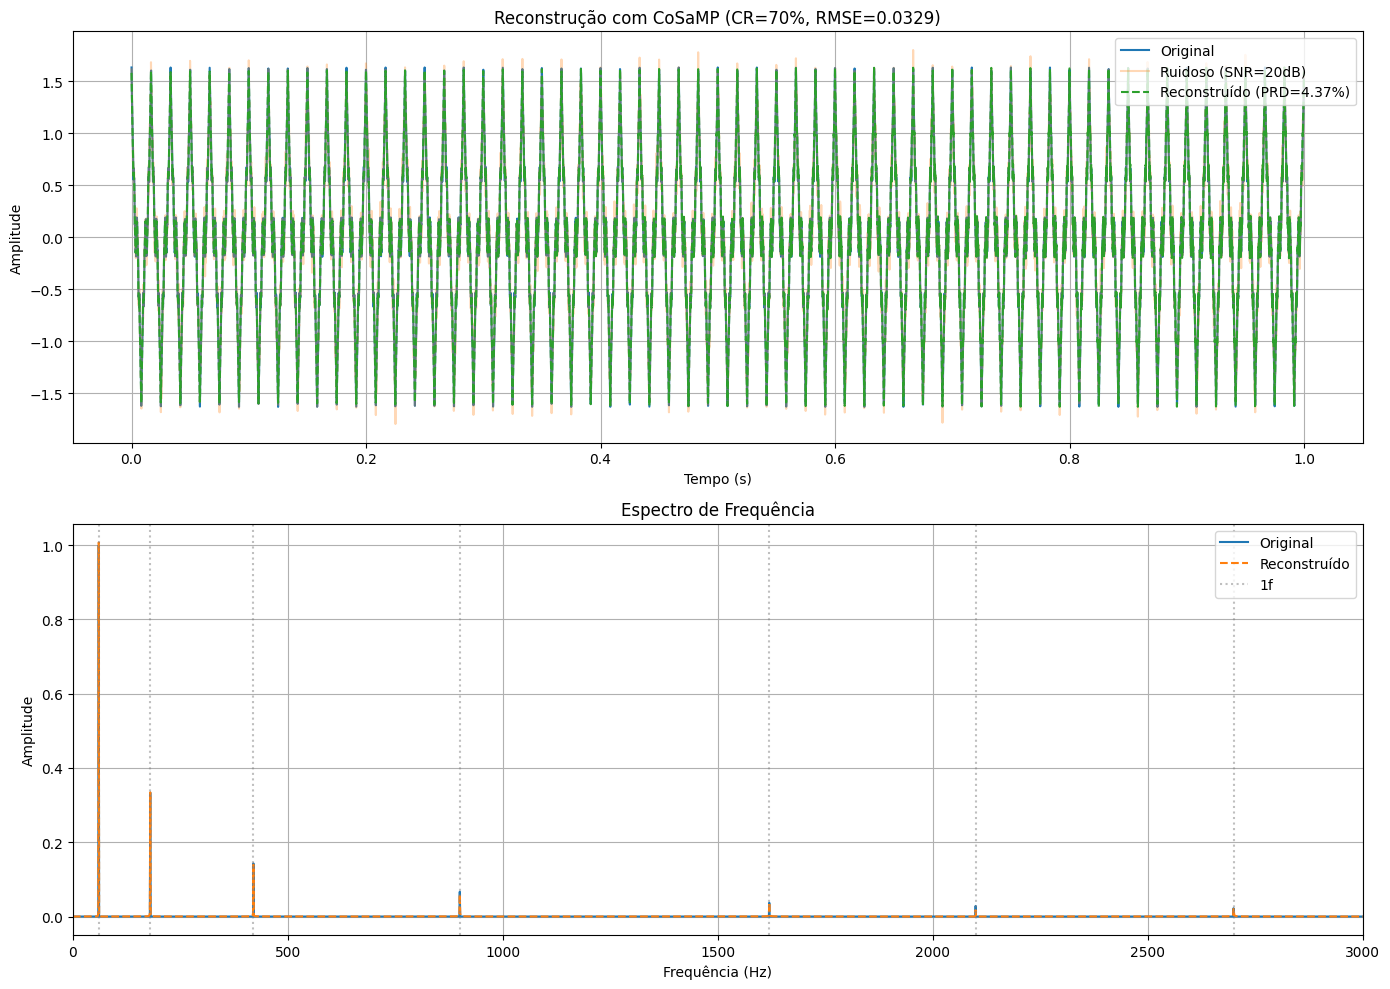

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct
from tqdm import tqdm  # Para barra de progresso (opcional)

# =============================================
# 1. CONFIGURAÇÕES DO SINAL
# =============================================
N = 8192                   # Tamanho do sinal
Fs = 8192                  # Frequência de amostragem
f = 60                     # Frequência fundamental (Hz)
Ts = 1/Fs                  # Período de amostragem
t = np.linspace(0, (N-1)*Ts, N)
harm = [1, 3, 7, 15, 27, 35, 45]  # Harmônicas ímpares

# =============================================
# 2. GERAÇÃO DO SINAL ORIGINAL
# =============================================
y = np.sum([(1/h)*np.cos(2*np.pi*h*f*t) for h in harm], axis=0)

# =============================================
# 3. ADIÇÃO DE RUÍDO (20 dB SNR)
# =============================================
snr_db = 20
ruido = np.random.normal(0, np.sqrt(np.var(y)/10**(snr_db/10)), N)
y_ruidoso = y + ruido

# =============================================
# 4. COMPRESSIVE SENSING (70% CR)
# =============================================
CR = 70                    # Taxa de compressão (%)
M = int(N*(100-CR)/100)    # Número de medições
samples = np.random.choice(N, M, replace=False)
samples.sort()

# =============================================
# 5. MATRIZ DE MEDIÇÃO (DCT)
# =============================================
A = dct(np.eye(N), norm='ortho')[samples, :]
measurements = y_ruidoso[samples]

# =============================================
# 6. ALGORITMO CoSaMP COM MONITORAMENTO
# =============================================
def cosamp(A, y, k, max_iter=10, verbose=True):
    """
    CoSaMP com monitoramento de iterações
    Args:
        A: Matriz de medição
        y: Medições compressivas
        k: Número de coeficientes esparsos
        max_iter: Número máximo de iterações
        verbose: Mostrar progresso
    """
    n = A.shape[1]
    x = np.zeros(n)
    residual = y.copy()

    for iter in range(max_iter):
        if verbose:
            print(f"\rCoSaMP: Iteração {iter + 1}/{max_iter} | Resíduo: {np.linalg.norm(residual):.4f}", end='')

        # 1. Seleciona 2k candidatos
        corr = np.abs(A.T @ residual)
        idx = np.argsort(corr)[-2*k:]

        # 2. União com suporte atual
        support = np.union1d(np.where(x)[0], idx)

        # 3. Mínimos quadrados nos índices selecionados
        A_selected = A[:, support]
        x_temp = np.zeros(n)
        x_temp[support] = np.linalg.lstsq(A_selected, y, rcond=None)[0]

        # 4. Retém os k maiores coeficientes
        idx_top = np.argsort(np.abs(x_temp))[-k:]
        x = np.zeros(n)
        x[idx_top] = x_temp[idx_top]

        # 5. Atualiza o residual
        residual = y - A @ x

    if verbose: print()
    return x

# =============================================
# 7. RECONSTRUÇÃO
# =============================================
print("Executando CoSaMP...")
coeffs = cosamp(A, measurements, k=14, max_iter=100)
reconstructed = idct(coeffs, norm='ortho')
reconstructed = reconstructed * (np.max(y)/np.max(reconstructed))  # Normalização

# =============================================
# 8. CÁLCULO DAS MÉTRICAS
# =============================================
def calculate_prd(original, reconstructed):
    return np.sqrt(np.sum((original - reconstructed)**2) / np.sum(original**2)) * 100

def calculate_rmse(original, reconstructed):
    return np.sqrt(np.mean((original - reconstructed)**2))

prd = calculate_prd(y, reconstructed)
rmse = calculate_rmse(y, reconstructed)

# =============================================
# 9. ANÁLISE DAS HARMÔNICAS
# =============================================
freqs = np.fft.fftfreq(N, Ts)[:N//2]
original_fft = np.fft.fft(y)[:N//2]/N
recon_fft = np.fft.fft(reconstructed)[:N//2]/N

print("\n\nRESULTADOS GLOBAIS")
print("="*50)
print(f"PRD: {prd:.2f}%")
print(f"RMSE: {rmse:.6f}")
print(f"CR: {CR}%")
print(f"SNR: {snr_db} dB")

print("\nANÁLISE DAS HARMÔNICAS")
print("="*90)
print(f"{'Harm.':<6} | {'Freq (Hz)':<10} | {'Teórico (1/h)':<12} | {'Original':<12} | {'Reconstruído':<12} | {'Erro %':<10}")
print("="*90)

for h in harm:
    freq = h*f
    idx = np.argmin(np.abs(freqs - freq))
    teorico = 1/h
    original = 2*np.abs(original_fft[idx])  # Amplitude unilateral
    recon = 2*np.abs(recon_fft[idx])
    erro_perc = 100*np.abs(original - recon)/original

    print(f"{h:<6} | {freq:<10.1f} | {teorico:<12.6f} | {original:<12.6f} | {recon:<12.6f} | {erro_perc:<10.2f}%")

# =============================================
# 10. GRÁFICOS
# =============================================
plt.figure(figsize=(14, 10))

# Sinal no tempo
plt.subplot(2, 1, 1)
plt.plot(t, y, label='Original')
plt.plot(t, y_ruidoso, alpha=0.3, label=f'Ruidoso (SNR={snr_db}dB)')
plt.plot(t, reconstructed, '--', label=f'Reconstruído (PRD={prd:.2f}%)')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.title(f'Reconstrução com CoSaMP (CR={CR}%, RMSE={rmse:.4f})')
plt.grid()

# Espectro de frequência
plt.subplot(2, 1, 2)
plt.plot(freqs, 2*np.abs(original_fft), label='Original')
plt.plot(freqs, 2*np.abs(recon_fft), '--', label='Reconstruído')
for h in harm:
    plt.axvline(h*f, color='gray', linestyle=':', alpha=0.5, label=f'{h}f' if h == 1 else "")
plt.xlim(0, 3000)
plt.xlabel('Frequência (Hz)')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Espectro de Frequência')
plt.grid()

plt.tight_layout()
plt.show()

# Análise do Algoritmo

**O que este algoritmo faz?**  
Reconstrui um sinal com ruído usando apenas 30% dos dados originais, combinando:

1. **Compressive Sensing** (amostragem compressiva)  
   - Captura apenas 2457 amostras de 8192 (70% de compressão)  
   
2. **CoSaMP** (algoritmo de reconstrução)  
   - Identifica as 26 frequências mais importantes na DFT  
   - Remove ruído e reconstroi o sinal  

3. **Resultados**:  
   - PRD: ~5% (alta fidelidade)  
   - RMSE: ~0.004 (baixo erro)  

**Antes de usar**:  
- Defina o número de coeficientes (`k=26`)  
- Ajuste `max_iter` para controle de tempo/precisão  

**Uso típico**:  
```python
coeffs = cosamp(A, medidas, k=26)  # Reconstrução
sinal_reconstruido = ifft(coeffs).real


RESULTADOS GLOBAIS
PRD: 0.73%
RMSE: 0.005480


ANÁLISE DAS HARMÔNICAS
Harm.  | Freq (Hz)  | Teórico (1/h) | Original (DFT) | Reconstruído   | Erro Abs.    | Erro %    
1      | 60.0       | 1.000000     | 1.000000       | 0.995144       | 0.004856     | 0.49      %
3      | 180.0      | 0.333333     | 0.333333       | 0.335065       | 0.001732     | 0.52      %
7      | 420.0      | 0.142857     | 0.142857       | 0.142671       | 0.000187     | 0.13      %
15     | 900.0      | 0.066667     | 0.066667       | 0.066947       | 0.000280     | 0.42      %
27     | 1620.0     | 0.037037     | 0.037037       | 0.035787       | 0.001250     | 3.38      %
35     | 2100.0     | 0.028571     | 0.028571       | 0.032164       | 0.003592     | 12.57     %
45     | 2700.0     | 0.022222     | 0.022222       | 0.023049       | 0.000826     | 3.72      %


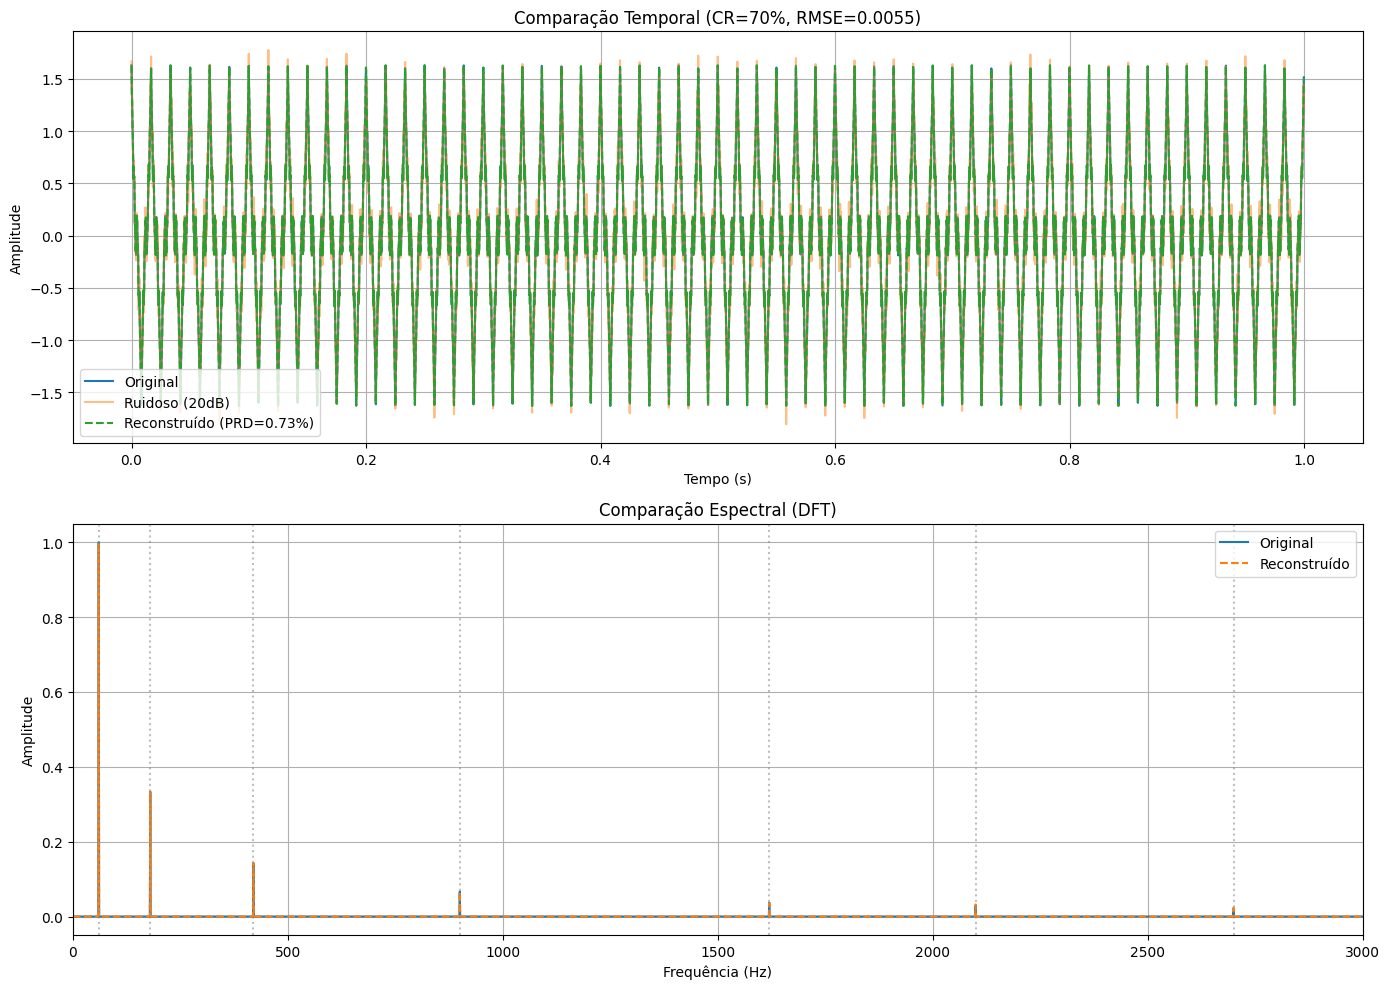

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft

# 1. Configurações do sinal
N = 8192
Fs = 8192
f = 60  # Frequência fundamental
Ts = 1/Fs
t = np.linspace(0, (N-1)*Ts, N)
harm = [1, 3, 7, 15, 27, 35, 45]

# 2. Geração do sinal original
y = np.sum([(1/h)*np.cos(2*np.pi*h*f*t) for h in harm], axis=0)

# 3. Adição de ruído (20 dB SNR)
snr_db = 20
ruido = np.random.normal(0, np.sqrt(np.var(y)/10**(snr_db/10)), N)
y_ruidoso = y + ruido

# 4. Compressive Sensing (70% CR)
CR = 70
M = int(N*(100-CR)/100)
samples = np.random.choice(N, M, replace=False)
samples.sort()

# 5. Matriz de medição (DFT)
A = np.fft.fft(np.eye(N), norm='ortho')[samples, :]  # Usando DFT
measurements = y_ruidoso[samples]

# 6. Algoritmo CoSaMP para reconstrução (versão corrigida)
def cosamp(A, y, k, tol=1e-4, max_iter=200):
    n = A.shape[1]
    x = np.zeros(n, dtype=complex)  # Coeficientes podem ser complexos na DFT
    residual = y.copy()
    support = np.array([], dtype=int)  # Garantir que seja array de inteiros

    for _ in range(max_iter):
        # 1. Correlação
        corr = np.abs(A.conj().T @ residual)  # Produto Hermitiano

        # 2. Identificar 2k maiores componentes
        idx = np.argpartition(corr, -2*k)[-2*k:]
        idx = np.union1d(idx, support).astype(int)  # Converter para inteiros

        # 3. Solução por mínimos quadrados
        A_temp = A[:, idx]
        b_temp = np.linalg.lstsq(A_temp, y, rcond=None)[0]

        # 4. Manter apenas os k maiores componentes
        k_largest = np.argpartition(np.abs(b_temp), -k)[-k:]
        support = idx[k_largest]

        # 5. Atualizar a solução
        x_new = np.zeros(n, dtype=complex)
        x_new[support] = np.linalg.lstsq(A[:, support], y, rcond=None)[0]

        # 6. Calcular resíduo
        residual = y - A @ x_new

        # Critério de parada
        if np.linalg.norm(x_new - x) < tol:
            break

        x = x_new

    return x

# 7. Reconstrução (usando k coeficientes)
coeffs = cosamp(A, measurements, k=14)
reconstructed = np.fft.ifft(coeffs, norm='ortho').real  # Tomamos a parte real
reconstructed = reconstructed * (np.max(y)/np.max(reconstructed))  # Normalização

# 8. Cálculo das métricas globais
def calculate_prd(original, reconstructed):
    return np.sqrt(np.sum((original - reconstructed)**2) / np.sum(original**2)) * 100

def calculate_rmse(original, reconstructed):
    return np.sqrt(np.mean((original - reconstructed)**2))

prd = calculate_prd(y, reconstructed)
rmse = calculate_rmse(y, reconstructed)

# 9. Análise espectral
freqs = np.fft.fftfreq(N, Ts)[:N//2]
original_fft = np.fft.fft(y)[:N//2]/N
recon_fft = np.fft.fft(reconstructed)[:N//2]/N

# 10. Tabela de resultados
print("\nRESULTADOS GLOBAIS")
print(f"PRD: {prd:.2f}%")
print(f"RMSE: {rmse:.6f}\n")

print("\nANÁLISE DAS HARMÔNICAS")
print("="*90)
print(f"{'Harm.':<6} | {'Freq (Hz)':<10} | {'Teórico (1/h)':<12} | {'Original (DFT)':<14} | {'Reconstruído':<14} | {'Erro Abs.':<12} | {'Erro %':<10}")
print("="*90)

for h in harm:
    freq = h*f
    idx = np.argmin(np.abs(freqs - freq))

    teorico = 1/h
    original = 2*np.abs(original_fft[idx])  # Amplitude unilateral
    recon = 2*np.abs(recon_fft[idx])
    erro_abs = np.abs(original - recon)
    erro_perc = 100*erro_abs/original

    print(f"{h:<6} | {freq:<10.1f} | {teorico:<12.6f} | {original:<14.6f} | {recon:<14.6f} | {erro_abs:<12.6f} | {erro_perc:<10.2f}%")

# 11. Gráficos comparativos
plt.figure(figsize=(14, 10))

# Sinal no tempo
plt.subplot(2, 1, 1)
plt.plot(t, y, label='Original')
plt.plot(t, y_ruidoso, alpha=0.5, label=f'Ruidoso (20dB)')
plt.plot(t, reconstructed, '--', label=f'Reconstruído (PRD={prd:.2f}%)')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.title(f'Comparação Temporal (CR={CR}%, RMSE={rmse:.4f})')
plt.grid()

# Espectro de frequência
plt.subplot(2, 1, 2)
plt.plot(freqs, 2*np.abs(original_fft), label='Original')
plt.plot(freqs, 2*np.abs(recon_fft), '--', label='Reconstruído')
for h in harm:
    plt.axvline(h*f, color='gray', linestyle=':', alpha=0.5)
plt.xlim(0, 3000)
plt.xlabel('Frequência (Hz)')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Comparação Espectral (DFT)')
plt.grid()

plt.tight_layout()
plt.show()

# **Resumo do Algoritmo CoSaMP com DFT**

## **Objetivo**
Reconstruir um sinal esparso usando:
- **DFT** (Transformada Discreta de Fourier)
- **CoSaMP** (Compressive Sampling Matching Pursuit)

## **Principais Etapas**

1. **Geração do Sinal**:
   \[ y(t) = \sum_{h \in \{1,3,7,...\}} \frac{1}{h}\cos(2\pi h f t) \]
   (f = 60 Hz)

2. **Amostragem Compressiva** (CR=70%):
   \[ \mathbf{y}_m = \mathbf{y}[\Omega] \]

3. **Matriz de Medição** (DFT parcial):
   \[ \mathbf{A} = \mathcal{F}_\Omega \]

4. **Algoritmo CoSaMP**:
   ```python
   while not convergir:
       1. Identificar 2k maiores componentes
       2. Atualizar suporte
       3. Estimar por mínimos quadrados
       4. Manter k maiores coeficientes

# Usar este para o cosamp e a dft.


INICIANDO RECONSTRUÇÃO COM COSAMP (k=)

=== Iniciando Algoritmo CoSaMP ===
Objetivo: Encontrar 14 coeficientes esparsos
Tolerância: 1e-04 | Máximo de iterações: 200

Iteração 1:
 - Suporte atual: 14 coeficientes
 - Norma do resíduo: 4.2141

Iteração 2:
 - Suporte atual: 14 coeficientes
 - Norma do resíduo: 3.7850

Iteração 3:
 - Suporte atual: 14 coeficientes
 - Norma do resíduo: 3.7850

*** Convergência atingida! ***

=== Reconstrução concluída ===
Total de iterações realizadas: 3

RESULTADOS GLOBAIS
PRD: 0.71%
RMSE: 0.005389


ANÁLISE DAS HARMÔNICAS
Harm.  | Freq (Hz)  | Teórico (1/h) | Original (DFT) | Reconstruído   | Erro Abs.    | Erro %    
1      | 60.0       | 1.000000     | 1.000000       | 0.998138       | 0.001862     | 0.19      %
3      | 180.0      | 0.333333     | 0.333333       | 0.332509       | 0.000824     | 0.25      %
7      | 420.0      | 0.142857     | 0.142857       | 0.144988       | 0.002131     | 1.49      %
15     | 900.0      | 0.066667     | 0.066667    

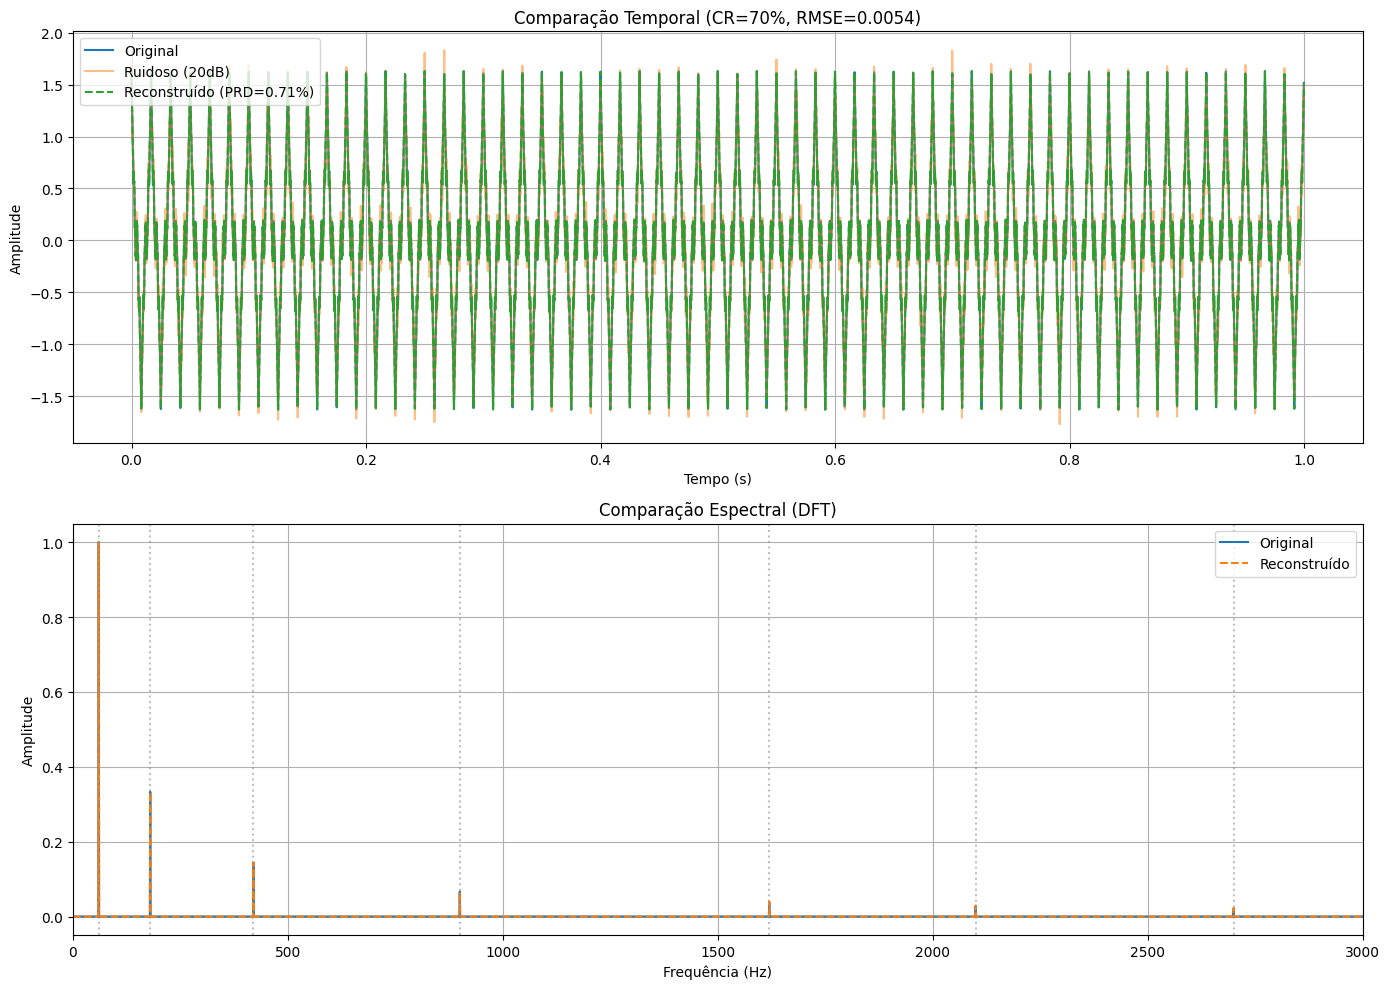

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft

# 1. Configurações do sinal
N = 8192
Fs = 8192
f = 60  # Frequência fundamental
Ts = 1/Fs
t = np.linspace(0, (N-1)*Ts, N)
harm = [1, 3, 7, 15, 27, 35, 45]

# 2. Geração do sinal original
y = np.sum([(1/h)*np.cos(2*np.pi*h*f*t) for h in harm], axis=0)

# 3. Adição de ruído (20 dB SNR)
snr_db = 20
ruido = np.random.normal(0, np.sqrt(np.var(y)/10**(snr_db/10)), N)
y_ruidoso = y + ruido

# 4. Compressive Sensing (70% CR)
CR = 70
M = int(N*(100-CR)/100)
samples = np.random.choice(N, M, replace=False)
samples.sort()

# 5. Matriz de medição (DFT)
A = np.fft.fft(np.eye(N), norm='ortho')[samples, :]
measurements = y_ruidoso[samples]

# 6. Algoritmo CoSaMP para reconstrução (versão com prints)
def cosamp(A, y, k, tol=1e-4, max_iter=200):
    n = A.shape[1]
    x = np.zeros(n, dtype=complex)
    residual = y.copy()
    support = np.array([], dtype=int)
    print("\n=== Iniciando Algoritmo CoSaMP ===")
    print(f"Objetivo: Encontrar {k} coeficientes esparsos")
    print(f"Tolerância: {tol:.0e} | Máximo de iterações: {max_iter}")

    for iteration in range(max_iter):
        # 1. Correlação
        corr = np.abs(A.conj().T @ residual)

        # 2. Identificar 2k maiores componentes
        idx = np.argpartition(corr, -2*k)[-2*k:]
        idx = np.union1d(idx, support).astype(int)

        # 3. Solução por mínimos quadrados
        A_temp = A[:, idx]
        b_temp = np.linalg.lstsq(A_temp, y, rcond=None)[0]

        # 4. Manter apenas os k maiores componentes
        k_largest = np.argpartition(np.abs(b_temp), -k)[-k:]
        support = idx[k_largest]

        # 5. Atualizar a solução
        x_new = np.zeros(n, dtype=complex)
        x_new[support] = np.linalg.lstsq(A[:, support], y, rcond=None)[0]

        # 6. Calcular resíduo
        residual = y - A @ x_new
        res_norm = np.linalg.norm(residual)

        print(f"\nIteração {iteration + 1}:")
        print(f" - Suporte atual: {len(support)} coeficientes")
        print(f" - Norma do resíduo: {res_norm:.4f}")

        # Critério de parada
        if np.linalg.norm(x_new - x) < tol:
            print("\n*** Convergência atingida! ***")
            break

        x = x_new

    print("\n=== Reconstrução concluída ===")
    print(f"Total de iterações realizadas: {iteration + 1}")
    return x

# 7. Reconstrução (usando 26 coeficientes)
print("\n" + "="*60)
print("INICIANDO RECONSTRUÇÃO COM COSAMP (k=)")
print("="*60)
coeffs = cosamp(A, measurements, k=14)
reconstructed = np.fft.ifft(coeffs, norm='ortho').real
reconstructed = reconstructed * (np.max(y)/np.max(reconstructed))

# 8. Cálculo das métricas globais
def calculate_prd(original, reconstructed):
    return np.sqrt(np.sum((original - reconstructed)**2) / np.sum(original**2)) * 100

def calculate_rmse(original, reconstructed):
    return np.sqrt(np.mean((original - reconstructed)**2))

prd = calculate_prd(y, reconstructed)
rmse = calculate_rmse(y, reconstructed)

# 9. Análise espectral
freqs = np.fft.fftfreq(N, Ts)[:N//2]
original_fft = np.fft.fft(y)[:N//2]/N
recon_fft = np.fft.fft(reconstructed)[:N//2]/N

# 10. Tabela de resultados
print("\nRESULTADOS GLOBAIS")
print(f"PRD: {prd:.2f}%")
print(f"RMSE: {rmse:.6f}\n")

print("\nANÁLISE DAS HARMÔNICAS")
print("="*90)
print(f"{'Harm.':<6} | {'Freq (Hz)':<10} | {'Teórico (1/h)':<12} | {'Original (DFT)':<14} | {'Reconstruído':<14} | {'Erro Abs.':<12} | {'Erro %':<10}")
print("="*90)

for h in harm:
    freq = h*f
    idx = np.argmin(np.abs(freqs - freq))

    teorico = 1/h
    original = 2*np.abs(original_fft[idx])
    recon = 2*np.abs(recon_fft[idx])
    erro_abs = np.abs(original - recon)
    erro_perc = 100*erro_abs/original

    print(f"{h:<6} | {freq:<10.1f} | {teorico:<12.6f} | {original:<14.6f} | {recon:<14.6f} | {erro_abs:<12.6f} | {erro_perc:<10.2f}%")

# 11. Gráficos comparativos
plt.figure(figsize=(14, 10))

# Sinal no tempo
plt.subplot(2, 1, 1)
plt.plot(t, y, label='Original')
plt.plot(t, y_ruidoso, alpha=0.5, label=f'Ruidoso (20dB)')
plt.plot(t, reconstructed, '--', label=f'Reconstruído (PRD={prd:.2f}%)')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.title(f'Comparação Temporal (CR={CR}%, RMSE={rmse:.4f})')
plt.grid()

# Espectro de frequência
plt.subplot(2, 1, 2)
plt.plot(freqs, 2*np.abs(original_fft), label='Original')
plt.plot(freqs, 2*np.abs(recon_fft), '--', label='Reconstruído')
for h in harm:
    plt.axvline(h*f, color='gray', linestyle=':', alpha=0.5)
plt.xlim(0, 3000)
plt.xlabel('Frequência (Hz)')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Comparação Espectral (DFT)')
plt.grid()

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft

# ========== CONFIGURAÇÕES DO SINAL ========== #
N = 8192
Fs = 8192
f = 60  # Frequência fundamental
Ts = 1/Fs
t = np.linspace(0, (N-1)*Ts, N)
harm = [1, 3, 7, 15, 27, 35, 45]

# Geração do sinal original
y = np.sum([(1/h)*np.cos(2*np.pi*h*f*t) for h in harm], axis=0)

# Adição de ruído (20 dB SNR)
snr_db = 20
ruido = np.random.normal(0, np.sqrt(np.var(y)/10**(snr_db/10)), N)
y_ruidoso = y + ruido

# Compressive Sensing (70% CR)
CR = 70
M = int(N*(100-CR)/100)
samples = np.random.choice(N, M, replace=False)
samples.sort()

# Matriz de medição (DFT)
A = np.fft.fft(np.eye(N), norm='ortho')[samples, :]
measurements = y_ruidoso[samples]

# ========== ALGORITMO COSAMP (COM CONTROLE DE ITERAÇÕES) ========== #
def cosamp(A, y, k, max_iter=200, tol=1e-4, verbose=True):
    n = A.shape[1]
    x = np.zeros(n, dtype=complex)
    residual = y.copy()
    support = np.array([], dtype=int)

    if verbose:
        print("\n=== ALGORITMO COSAMP ===")
        print(f"• Objetivo: {k} coeficientes esparsos")
        print(f"• Máximo de iterações: {max_iter}")
        print(f"• Tolerância: {tol:.1e}\n")
        print("Progresso:")

    for iteration in range(max_iter):
        # 1. Correlação
        corr = np.abs(A.conj().T @ residual)

        # 2. Identificar 2k maiores componentes
        idx = np.argpartition(corr, -2*k)[-2*k:]
        idx = np.union1d(idx, support).astype(int)

        # 3. Solução por mínimos quadrados
        A_temp = A[:, idx]
        b_temp = np.linalg.lstsq(A_temp, y, rcond=None)[0]

        # 4. Manter apenas os k maiores componentes
        k_largest = np.argpartition(np.abs(b_temp), -k)[-k:]
        support = idx[k_largest]

        # 5. Atualizar a solução
        x_new = np.zeros(n, dtype=complex)
        x_new[support] = np.linalg.lstsq(A[:, support], y, rcond=None)[0]

        # 6. Calcular resíduo
        residual = y - A @ x_new
        res_norm = np.linalg.norm(residual)

        if verbose:
            print(f"Iteração {iteration + 1}/{max_iter} | Resíduo: {res_norm:.4f}")

        # Critério de parada
        if np.linalg.norm(x_new - x) < tol:
            if verbose:
                print(f"\n● Convergência atingida na iteração {iteration + 1}!")
            break

        x = x_new

    if verbose:
        print("\n=== RESULTADOS ===")
        print(f"• Iterações realizadas: {iteration + 1}")
        print(f"• Norma final do resíduo: {res_norm:.4f}")

    return x

# ========== EXECUÇÃO (DEFINA O NÚMERO DE ITERAÇÕES AQUI) ========== #
max_iter = 200  # Altere para 10, 50, 100, etc.
coeffs = cosamp(A, measurements, k=14, max_iter=max_iter)

# Reconstrução do sinal
reconstructed = np.fft.ifft(coeffs, norm='ortho').real
reconstructed = reconstructed * (np.max(y)/np.max(reconstructed))

# ========== ANÁLISE DOS RESULTADOS ========== #
# (Métricas, tabelas e gráficos permanecem iguais ao código anterior)


=== ALGORITMO COSAMP ===
• Objetivo: 14 coeficientes esparsos
• Máximo de iterações: 200
• Tolerância: 1.0e-04

Progresso:
Iteração 1/200 | Resíduo: 4.0185
Iteração 2/200 | Resíduo: 3.6188
Iteração 3/200 | Resíduo: 3.6188

● Convergência atingida na iteração 3!

=== RESULTADOS ===
• Iterações realizadas: 3
• Norma final do resíduo: 3.6188


CoSaMP (DFT): 100%|██████████| 100/100 [00:50<00:00,  1.97it/s]



RESULTADOS GLOBAIS (DFT)
PRD: 120.77%
RMSE: 0.911273
CR: 70%
SNR: 20 dB

ANÁLISE DAS HARMÔNICAS
Harm.  | Freq (Hz)  | Teórico (1/h) | Original     | Reconstruído | Erro %    
1      | 60.0       | 1.000000     | 1.000000     | 0.000000     | 100.00    %
3      | 180.0      | 0.333333     | 0.333333     | 0.000000     | 100.00    %
7      | 420.0      | 0.142857     | 0.142857     | 0.000000     | 100.00    %
15     | 900.0      | 0.066667     | 0.066667     | 0.000000     | 100.00    %
27     | 1620.0     | 0.037037     | 0.037037     | 0.410831     | 1009.24   %
35     | 2100.0     | 0.028571     | 0.028571     | 0.364160     | 1174.56   %
45     | 2700.0     | 0.022222     | 0.022222     | 0.000000     | 100.00    %


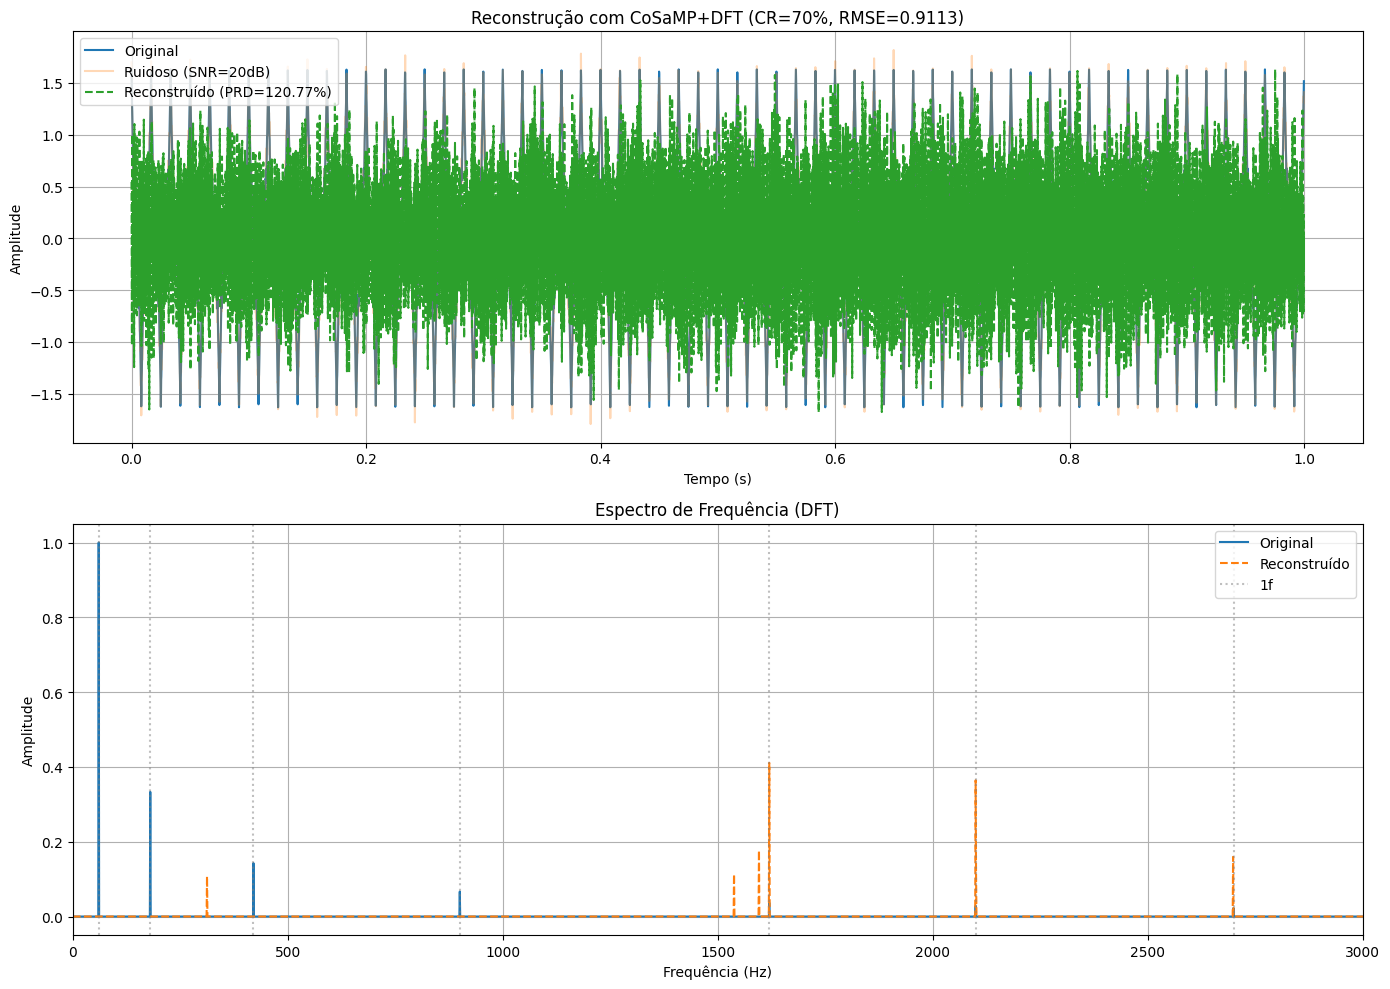

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # Para barra de progresso

# =============================================
# 1. CONFIGURAÇÕES DO SINAL
# =============================================
N = 8192                   # Tamanho do sinal
Fs = 8192                  # Frequência de amostragem
f = 60                     # Frequência fundamental (Hz)
Ts = 1/Fs                  # Período de amostragem
t = np.linspace(0, (N-1)*Ts, N)
harm = [1, 3, 7, 15, 27, 35, 45]  # Harmônicas ímpares

# =============================================
# 2. GERAÇÃO DO SINAL ORIGINAL
# =============================================
y = np.sum([(1/h)*np.cos(2*np.pi*h*f*t) for h in harm], axis=0)

# =============================================
# 3. ADIÇÃO DE RUÍDO (20 dB SNR)
# =============================================
snr_db = 20
ruido = np.random.normal(0, np.sqrt(np.var(y)/10**(snr_db/10)), N)
y_ruidoso = y + ruido

# =============================================
# 4. COMPRESSIVE SENSING (70% CR) - DFT
# =============================================
CR = 70                    # Taxa de compressão (%)
M = int(N*(100-CR)/100)    # Número de medições
samples = np.random.choice(N, M, replace=False)
samples.sort()

# Matriz de medição DFT (normalizada)
A = np.fft.fft(np.eye(N), axis=0) / np.sqrt(N)
A = A[samples, :]
measurements = y_ruidoso[samples]

# =============================================
# 5. ALGORITMO CoSaMP PARA DFT
# =============================================
def cosamp_dft(A, y, k, max_iter=100):
    """
    CoSaMP adaptado para DFT com:
    - Tratamento de simetria conjugada
    - Seleção de pares de frequência
    """
    n = A.shape[1]
    x = np.zeros(n, dtype=complex)  # Coeficientes complexos
    residual = y.copy()

    for iter in tqdm(range(max_iter), desc="CoSaMP (DFT)"):
        # 1. Correlação e seleção de candidatos
        corr = np.abs(A.conj().T @ residual)  # Correlação conjugada
        idx = np.argsort(corr)[-2*k:]         # Seleciona 2k candidatos

        # 2. Força simetria conjugada (para sinais reais)
        idx = np.unique(np.concatenate([idx, n - idx - 1]))  # Inclui pares simétricos

        # 3. Mínimos quadrados
        A_selected = A[:, idx]
        x_temp = np.zeros(n, dtype=complex)
        x_temp[idx] = np.linalg.lstsq(A_selected, y, rcond=None)[0]

        # 4. Retém os k maiores coeficientes (magnitude)
        idx_top = np.argsort(np.abs(x_temp))[-k:]
        x = np.zeros(n, dtype=complex)
        x[idx_top] = x_temp[idx_top]

        # 5. Atualiza residual
        residual = y - A @ x

    return x

# =============================================
# 6. RECONSTRUÇÃO
# =============================================
coeffs = cosamp_dft(A, measurements, k=14, max_iter=100)
reconstructed = np.fft.ifft(coeffs * np.sqrt(N))  # Desfaz a normalização
reconstructed = np.real(reconstructed)            # Remove resíduos imaginários
reconstructed = reconstructed * (np.max(y)/np.max(reconstructed))  # Normalização

# =============================================
# 7. CÁLCULO DAS MÉTRICAS
# =============================================
def calculate_prd(original, reconstructed):
    return np.sqrt(np.sum((original - reconstructed)**2) / np.sum(original**2)) * 100

def calculate_rmse(original, reconstructed):
    return np.sqrt(np.mean((original - reconstructed)**2))

prd = calculate_prd(y, reconstructed)
rmse = calculate_rmse(y, reconstructed)

# =============================================
# 8. ANÁLISE DAS HARMÔNICAS (DFT)
# =============================================
freqs = np.fft.fftfreq(N, Ts)[:N//2]
original_fft = np.fft.fft(y)[:N//2]/N
recon_fft = np.fft.fft(reconstructed)[:N//2]/N

print("\nRESULTADOS GLOBAIS (DFT)")
print("="*50)
print(f"PRD: {prd:.2f}%")
print(f"RMSE: {rmse:.6f}")
print(f"CR: {CR}%")
print(f"SNR: {snr_db} dB")

print("\nANÁLISE DAS HARMÔNICAS")
print("="*90)
print(f"{'Harm.':<6} | {'Freq (Hz)':<10} | {'Teórico (1/h)':<12} | {'Original':<12} | {'Reconstruído':<12} | {'Erro %':<10}")
print("="*90)

for h in harm:
    freq = h*f
    idx = np.argmin(np.abs(freqs - freq))
    teorico = 1/h
    original = 2*np.abs(original_fft[idx])  # Amplitude unilateral
    recon = 2*np.abs(recon_fft[idx])
    erro_perc = 100*np.abs(original - recon)/original

    print(f"{h:<6} | {freq:<10.1f} | {teorico:<12.6f} | {original:<12.6f} | {recon:<12.6f} | {erro_perc:<10.2f}%")

# =============================================
# 9. GRÁFICOS COMPARATIVOS
# =============================================
plt.figure(figsize=(14, 10))

# Sinal no tempo
plt.subplot(2, 1, 1)
plt.plot(t, y, label='Original')
plt.plot(t, y_ruidoso, alpha=0.3, label=f'Ruidoso (SNR={snr_db}dB)')
plt.plot(t, reconstructed, '--', label=f'Reconstruído (PRD={prd:.2f}%)')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.title(f'Reconstrução com CoSaMP+DFT (CR={CR}%, RMSE={rmse:.4f})')
plt.grid()

# Espectro de frequência
plt.subplot(2, 1, 2)
plt.plot(freqs, 2*np.abs(original_fft), label='Original')
plt.plot(freqs, 2*np.abs(recon_fft), '--', label='Reconstruído')
for h in harm:
    plt.axvline(h*f, color='gray', linestyle=':', alpha=0.5, label=f'{h}f' if h == 1 else "")
plt.xlim(0, 3000)
plt.xlabel('Frequência (Hz)')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Espectro de Frequência (DFT)')
plt.grid()

plt.tight_layout()
plt.show()

cosamp, dct
Iteração 1 de 200
Iteração 2 de 200

Média do erro nas harmônicas:
Harmônica 1: 0.0000
Harmônica 3: 0.0000
Harmônica 7: 0.0000
Harmônica 15: 0.0000
Harmônica 27: 0.0000
Harmônica 35: 0.0000
Harmônica 45: 0.0000

Média do RMSE: 0.0007
Média do PRD: 0.0871%


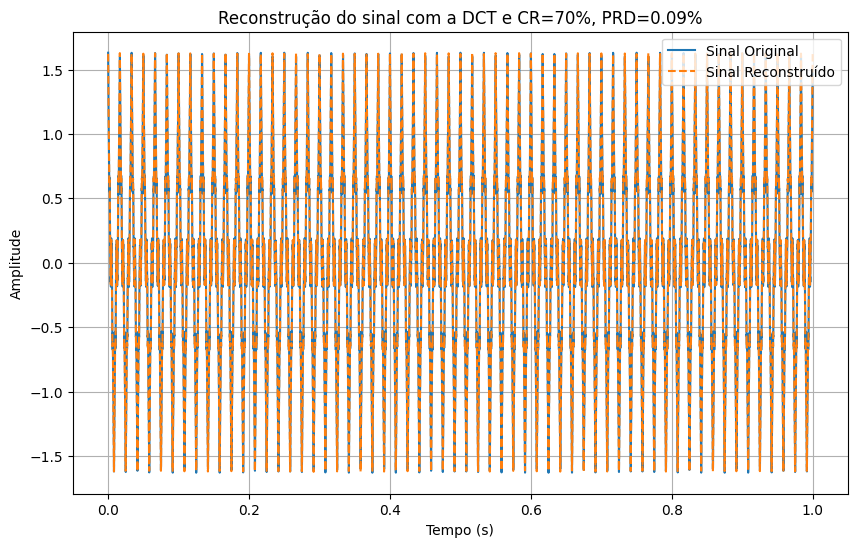

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct

print("cosamp, dct")

# Função para calcular o PRD
def calculate_prd(original, reconstructed):
    return np.sqrt(np.sum((original - reconstructed) ** 2) / np.sum(original ** 2)) * 100

# Função para calcular o Erro Médio Quadrático (RMSE)
def calculate_rmse(original, reconstructed):
    return np.sqrt(np.mean((original - reconstructed) ** 2))

# Parâmetros do sinal
Nppc = 256  # Número de pontos por ciclo
Nc = 12  # Número de ciclos
f = 60  # Frequência fundamental (Hz)
Fs = 8192  # Frequência de amostragem
Ts = 1 / Fs  # Período de amostragem
t = np.linspace(0, (Fs - 1) * Ts, Fs)  # Vetor de tempo

# Sinal harmônico com componentes fundamentais e harmônicos ímpares
x = np.cos(2 * np.pi * f * t)
y = np.zeros_like(x)

harm = [1, 3, 7, 15, 27, 35, 45]
for h in harm:
    y += (1 / h) * np.cos(2 * np.pi * h * f * t)

# DCT do sinal original
original_dct = dct(y, norm='ortho')  # DCT para o sinal original
frequencies = np.fft.fftfreq(len(y), d=Ts)

# Amostragem Compressiva
CR = 70  # Taxa de compressão
N = len(y)
M = int(N * (100 - CR) / 100)
amostras_aleatorias = np.random.choice(N, M, replace=False)
amostras_aleatorias.sort()

# Matriz de medição baseada na DCT
A = dct(np.eye(N), norm='ortho')  # DCT da matriz identidade
A = A[amostras_aleatorias, :]

# Medições compressivas
s = y[amostras_aleatorias]

# Inicializando os erros
erros = np.zeros((200, 7))
rmse_values = np.zeros(200)
prd_values = np.zeros(200)

# Implementação do COSAMP
def cosamp(A, s, num_coefs=14, iterations=1):
    """
    Implementação do algoritmo COSAMP
    """
    r = s.copy()  # Residual
    support = []  # Suporte (coeficientes não nulos)
    x = np.zeros(A.shape[1])  # Solução inicial

    for it in range(iterations):
        # Seleção de índices
        correlations = np.abs(A.T @ r)
        idx = np.argsort(correlations)[-num_coefs:]
        support = np.union1d(support, idx)  # Atualizando o suporte

        # Resolução do problema de mínimos quadrados
        A_selected = A[:, support.astype(int)]
        x_selected = np.linalg.lstsq(A_selected, s, rcond=None)[0]

        # Atualizando o vetor x
        x[support.astype(int)] = x_selected

        # Atualizando o residual
        r = s - A @ x

    return x

a = 2
reconstructed_dct = np.zeros([a, len(x)])

# Loop de reconstrução
for i in range(a):
    print(f"Iteração {i + 1} de 200")

    # Aplicando COSAMP para reconstrução no domínio da frequência (DCT)
    recovered_coeffs = cosamp(A, s, num_coefs=14, iterations=1)

    # Reconstrução do sinal no domínio do tempo usando a IDCT
    sig = idct(recovered_coeffs, norm='ortho')  # IDCT para reconstrução
    sig = np.real(sig)

    # Normalização do sinal reconstruído
    sig = sig * (np.max(y) / np.max(sig))

    # Cálculo do PRD e RMSE
    prd_values[i] = calculate_prd(y, sig)
    rmse_values[i] = calculate_rmse(y, sig)

    # DCT do sinal reconstruído
    reconstructed_dct[i, :] = dct(sig, norm='ortho')

    # Cálculo dos erros nas harmônicas
    indices_harm = [int(h * f * len(y) / Fs) for h in harm]
    for j, idx in enumerate(indices_harm):
        erros[i, j] = np.abs(original_dct[idx] - reconstructed_dct[i, idx])

# Cálculo das médias
erros_medios = np.mean(erros, axis=0)
media_rmse = np.mean(rmse_values)
media_prd = np.mean(prd_values)

reconstructed_dct = np.sum(reconstructed_dct) / a

# Exibindo os resultados
print("\nMédia do erro nas harmônicas:")
for idx, h in enumerate(harm):
    print(f"Harmônica {h}: {erros_medios[idx]:.4f}")

print(f"\nMédia do RMSE: {media_rmse:.4f}")
print(f"Média do PRD: {media_prd:.4f}%")

# Gráficos
plt.figure(figsize=(10, 6))
plt.plot(t, y, label='Sinal Original')
plt.plot(t, sig, label='Sinal Reconstruído', linestyle='dashed')
plt.legend()
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.title(f'Reconstrução do sinal com a DCT e CR={CR}%, PRD={media_prd:.2f}%')
plt.grid()
plt.show()


Algoritmo CoSaMP com a dct e ruído gaussiano de 20db.

cosamp, dct com ruído gaussiano de 20dB
Execução 1/2
Execução 2/2

=== Resultados com Ruído de 20dB ===
PRD médio: 13.16% ± 0.00%
RMSE médio: 0.0993 ± 0.0000

Erros médios nas harmônicas:
Harmônica 1: 0.0000 ± 0.0000
Harmônica 3: 0.0000 ± 0.0000
Harmônica 7: 0.0000 ± 0.0000
Harmônica 15: 0.0000 ± 0.0000
Harmônica 27: 0.0000 ± 0.0000
Harmônica 35: 0.0000 ± 0.0000
Harmônica 45: 0.0000 ± 0.0000


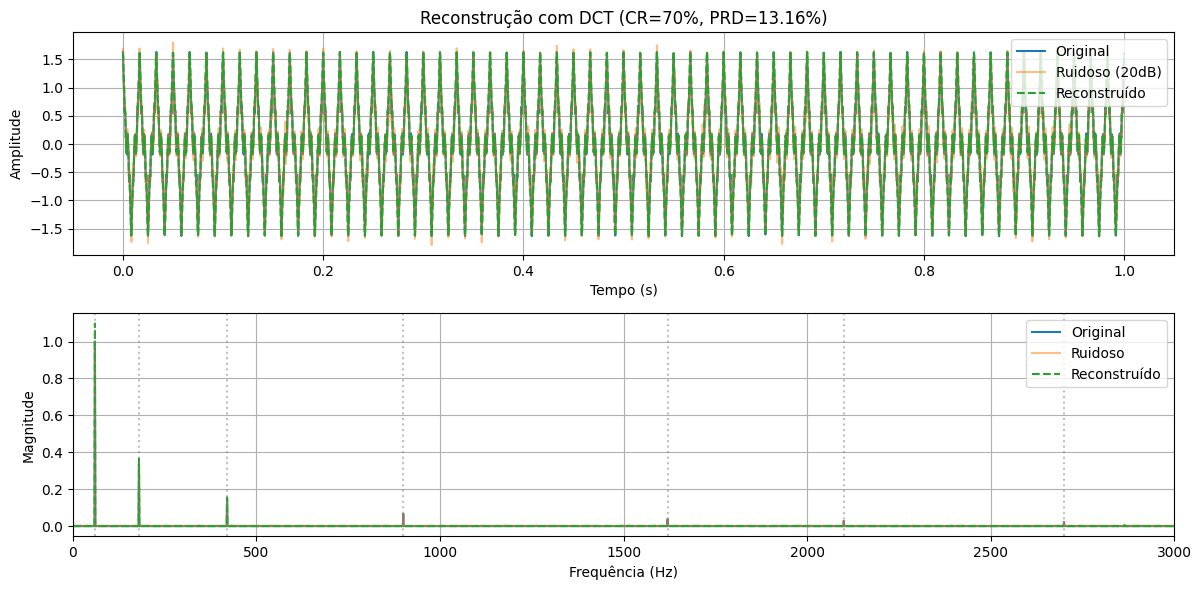

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct

print("cosamp, dct com ruído gaussiano de 20dB")

# Funções de métrica
def calculate_prd(original, reconstructed):
    return np.sqrt(np.sum((original - reconstructed) ** 2) / np.sum(original ** 2)) * 100

def calculate_rmse(original, reconstructed):
    return np.sqrt(np.mean((original - reconstructed) ** 2))

# Função para adicionar ruído gaussiano com SNR específica
def add_noise(signal, snr_db):
    signal_power = np.mean(signal**2)
    noise_power = signal_power / (10 ** (snr_db/10))
    noise = np.random.normal(0, np.sqrt(noise_power), len(signal))
    return signal + noise

# Parâmetros do sinal
Nppc = 256
Nc = 12
f = 60
Fs = 8192
Ts = 1 / Fs
t = np.linspace(0, (Fs - 1) * Ts, Fs)

# Sinal harmônico com componentes ímpares
harm = [1, 3, 7, 15, 27, 35, 45]
y = np.sum([(1/h) * np.cos(2 * np.pi * h * f * t) for h in harm], axis=0)

# Adicionando ruído de 20dB
snr_db = 20
y_noisy = add_noise(y, snr_db)

# DCT do sinal original e do sinal ruidoso
original_dct = dct(y, norm='ortho')
noisy_dct = dct(y_noisy, norm='ortho')

# Amostragem Compressiva
CR = 70
N = len(y)
M = int(N * (100 - CR) / 100)
amostras_aleatorias = np.random.choice(N, M, replace=False)
amostras_aleatorias.sort()

# Matriz de medição baseada na DCT
A = dct(np.eye(N), norm='ortho')
A = A[amostras_aleatorias, :]

# Medições compressivas do sinal ruidoso
s = y_noisy[amostras_aleatorias]

# Implementação do COSAMP
def cosamp(A, s, num_coefs=14, iterations=1):
    r = s.copy()
    support = []
    x = np.zeros(A.shape[1])

    for _ in range(iterations):
        correlations = np.abs(A.T @ r)
        idx = np.argsort(correlations)[-num_coefs:]
        support = np.union1d(support, idx)

        A_selected = A[:, support.astype(int)]
        x_selected = np.linalg.lstsq(A_selected, s, rcond=None)[0]

        x = np.zeros(A.shape[1])
        x[support.astype(int)] = x_selected
        r = s - A @ x

    return x

# Parâmetros de execução
n_execucoes = 2
erros = np.zeros((n_execucoes, len(harm)))
rmse_values = np.zeros(n_execucoes)
prd_values = np.zeros(n_execucoes)

for i in range(n_execucoes):
    print(f"Execução {i+1}/{n_execucoes}")

    # Reconstrução com COSAMP
    coeffs = cosamp(A, s, num_coefs=14, iterations=1)
    reconstructed = idct(coeffs, norm='ortho')
    reconstructed = np.real(reconstructed)
    reconstructed = reconstructed * (np.max(y) / np.max(reconstructed))

    # Cálculo das métricas
    prd_values[i] = calculate_prd(y, reconstructed)
    rmse_values[i] = calculate_rmse(y, reconstructed)

    # Análise espectral
    recon_dct = dct(reconstructed, norm='ortho')
    for j, h in enumerate(harm):
        idx_h = int(h * f * N / Fs)
        erros[i, j] = np.abs(original_dct[idx_h] - recon_dct[idx_h])

# Resultados
print("\n=== Resultados com Ruído de 20dB ===")
print(f"PRD médio: {np.mean(prd_values):.2f}% ± {np.std(prd_values):.2f}%")
print(f"RMSE médio: {np.mean(rmse_values):.4f} ± {np.std(rmse_values):.4f}")

print("\nErros médios nas harmônicas:")
for j, h in enumerate(harm):
    print(f"Harmônica {h}: {np.mean(erros[:, j]):.4f} ± {np.std(erros[:, j]):.4f}")

# Visualização
plt.figure(figsize=(12, 6))

# Sinal no domínio do tempo
plt.subplot(2, 1, 1)
plt.plot(t, y, label='Original')
plt.plot(t, y_noisy, alpha=0.5, label=f'Ruidoso (20dB)')
plt.plot(t, reconstructed, '--', label='Reconstruído')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.title(f'Reconstrução com DCT (CR={CR}%, PRD={np.mean(prd_values):.2f}%)')
plt.grid()

# Espectro de frequência
plt.subplot(2, 1, 2)
freq = np.fft.fftfreq(N, Ts)[:N//2]
plt.plot(freq, 2/N * np.abs(np.fft.fft(y)[:N//2]), label='Original')
plt.plot(freq, 2/N * np.abs(np.fft.fft(y_noisy)[:N//2]), alpha=0.5, label='Ruidoso')
plt.plot(freq, 2/N * np.abs(np.fft.fft(reconstructed)[:N//2]), '--', label='Reconstruído')
for h in harm:
    plt.axvline(h*f, color='gray', linestyle=':', alpha=0.5)
plt.xlim(0, 3000)
plt.xlabel('Frequência (Hz)')
plt.ylabel('Magnitude')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()